# Deep learning models for age prediction on EEG data

This notebook uses deep learning methods to predict the age of infants using EEG data. The EEG data is preprocessed as shown in the notebook 'Deep learning EEG_dataset preprocessing raw'. 

In [37]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_RAW_DATA, PATH_DATA_PROCESSED_DL, PATH_MODELS

## Load preprocessed data

The data can be found in 'PATH_DATA_PROCESSED_DL'. This is a single folder with all the data and metadata. The EEG data is in the .zarr files and the metadata is in .csv files. The .zarr files are divided in chunks of 1-second epochs from the same subject and the metadata contains the information like the subject's identification code and age. 

Ideally, all the data (epochs + age as label) is loaded in memory and models are trained on this data. The data must be split in train/validation/test and subjects shouldn't be in more than one of these splits. However, the data set is too large to fit in memory.

Therefore, a generator is used that loads the data on the fly from the files, tackling the issue of limited memory. Additionally, because epochs often contain a lot of noise, multiple random epochs of the same subjects at the same age (e.g. 40) can be averaged to create a new epoch. 

In [38]:
# Load all the metadata

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_DL)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_DL, file_name))[0] for file_name in fnmatch.filter(file_names, "*.zarr")]

# Step 3: Load all the metadata
frames = []

for idx, feature_file in enumerate(files):
    df_metadata = pd.read_csv(feature_file.replace("processed_raw_", "processed_metadata_") + ".csv")
    frames.append(df_metadata)

df_metadata = pd.concat(frames) 

# Step 4: Add missing age information based on the age group the subject is in
df_metadata['age_months'].fillna(df_metadata['age_group'], inplace=True)
df_metadata['age_days'].fillna(df_metadata['age_group']*30, inplace=True)
df_metadata['age_years'].fillna(df_metadata['age_group']/12, inplace=True)

# Step 5: List all the unique subject IDs
subject_ids = list(set(df_metadata["code"].tolist()))

In [39]:
from sklearn.model_selection import train_test_split

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

In [40]:
df_metadata

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,23,/Volumes/Seagate Expansion Drive/ePodium/Data/...,023_35_mc_mmn36,35,1052.0,35.066667,2.922222
0,337,/Volumes/Seagate Expansion Drive/ePodium/Data/...,337_23_jc_mmn_36_wk,23,692.0,23.066667,1.922222
0,456,/Volumes/Seagate Expansion Drive/ePodium/Data/...,456_23_md_mmn36_wk,23,691.0,23.033333,1.919444
0,328,/Volumes/Seagate Expansion Drive/ePodium/Data/...,328_23_jc_mmn36_wk,23,699.0,23.300000,1.941667
0,314,/Volumes/Seagate Expansion Drive/ePodium/Data/...,314_29_mmn_36_wk,29,877.0,29.233333,2.436111
...,...,...,...,...,...,...,...
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_29_jc_mmn25_wk,29,858.0,28.600000,2.383333
0,9,/Volumes/Seagate Expansion Drive/ePodium/Data/...,009_23_jc_mmn58,23,692.0,23.066667,1.922222
0,751,/Volumes/Seagate Expansion Drive/ePodium/Data/...,751-452-29m-jr-mmn36,29,869.0,28.966667,2.413889
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_17_jc_mmn25_wk,17,512.0,17.066667,1.422222


In [41]:
from dataset_generator import DataGenerator

In [42]:
train_generator = DataGenerator(list_IDs = IDs_train,
                                BASE_PATH = PATH_DATA_PROCESSED_DL,
                                metadata = df_metadata,
                                n_average = 30,
                                batch_size = 10,
                                iter_per_epoch = 30,
                                n_timepoints = 501, 
                                n_channels=30, 
                                shuffle=True)

train_generator_noise = DataGenerator(list_IDs = IDs_train,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator = DataGenerator(list_IDs = IDs_val,
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

test_generator = DataGenerator(list_IDs = IDs_test,
                               BASE_PATH = PATH_DATA_PROCESSED_DL,
                               metadata = df_metadata,
                               n_average = 30,
                               batch_size = 10,
                               iter_per_epoch = 100,
                               n_timepoints = 501,
                               n_channels=30,
                               shuffle=True)

# Testing with best model from initial experiments (InceptionTime)

In [43]:
n_timesteps = 501
n_features = 30
n_outputs = 1

input_shape = (n_timesteps, n_features)

In [44]:
# Helper functions

def evaluate_model(model):
    """ Evaluates the model """
    model.evaluate(train_generator)
    model.evaluate(val_generator)
    model.evaluate(test_generator) 
    
def print_few_predictions(model):
    """ Prints a few predictions, as a sanity check """
    x_test, y_test = test_generator.__getitem__(0)

    print(model.predict(x_test))
    print(y_test)
    
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
output_filename = 'Inception_regressor_05'
# 'Inception_regressor_01' (n_average = 40, gaussian_noise = 0.01, MAE)
# 'Inception_regressor_02' (n_average = 1, gaussian_noise = 0.01, MAE)
# 'Inception_regressor_03' (n_average = 40, gaussian_noise = 0.01, MSE)
# 'Inception_regressor_04' (n_average = 1, gaussian_noise = 0.01, MSE)
# 'Inception_regressor_05' (n_average = 100, gaussian_noise = 0.01, MAE)

output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001, verbose=1)

In [14]:
import tensorflow as tf
import numpy as np
import time

from utils import save_logs
from utils import calculate_metrics
from utils import save_test_duration


class Regressor_Inception:

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=41, nb_epochs=1500):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'inception_model_init.hdf5')

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = tf.keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = tf.keras.layers.Concatenate(axis=2)(conv_list)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        x = tf.keras.layers.Add()([shortcut_y, out_tensor])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = tf.keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=50)(x)
        flat_layer = tf.keras.layers.Flatten()(pooling_layer)
        dense_layer = tf.keras.layers.Dense(128, activation='relu')(flat_layer)
        output_layer = tf.keras.layers.Dense(1)(dense_layer)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
#         model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                      metrics=[tf.keras.metrics.RootMeanSquaredError(),
                               tf.keras.metrics.MeanAbsoluteError()])

        return model

    def fit(self, x, validation_data, plot_test_acc=False):
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        hist = self.model.fit(x=x, validation_data=validation_data,
                              batch_size=mini_batch_size, epochs=self.nb_epochs,
                              verbose=self.verbose, callbacks=self.callbacks)

        self.model.save(self.output_directory + 'inception_last_model.hdf5')

        return hist

    def predict(self, x_test, y_true, x_train, y_train, y_test, return_df_metrics=True):
        start_time = time.time()
        model_path = self.output_directory + 'inception_best_model.hdf5'
        model = tf.keras.models.load_model(model_path)
        y_pred = model.predict(x_test, batch_size=self.batch_size)
        if return_df_metrics:
            y_pred = np.argmax(y_pred, axis=1)
            df_metrics = calculate_metrics(y_true, y_pred, 0.0)
            return df_metrics
        else:
            test_duration = time.time() - start_time
            save_test_duration(self.output_directory + 'test_duration.csv', test_duration)
            return y_pred

In [15]:
model = Regressor_Inception(PATH_MODELS, input_shape, 1, verbose=True).model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 501, 30)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 501, 32)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 501, 30)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 501, 32)      40960       conv1d[0][0]                     
______________________________________________________________________________________________

In [96]:
%%time

epochs = 1500

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
143/143 [==============================] - 249s 2s/step - loss: 14.8795 - root_mean_squared_error: 21.7512 - mean_absolute_error: 14.8795 - val_loss: 14.4589 - val_root_mean_squared_error: 18.1789 - val_mean_absolute_error: 14.4589

Epoch 00001: val_loss improved from inf to 14.45891, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 2/1500
143/143 [==============================] - 238s 2s/step - loss: 8.9878 - root_mean_squared_error: 11.2585 - mean_absolute_error: 8.9878 - val_loss: 8.4816 - val_root_mean_squared_error: 10.7197 - val_mean_absolute_error: 8.4816

Epoch 00002: val_loss improved from 14.45891 to 8.48164, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 3/1500
143/143 [==============================] - 241s 2s/step - loss: 7.9297 - root_mean_squared_error: 9.8073 - mean_absolute_error: 7.9297 - val_loss: 8.62


Epoch 00024: val_loss did not improve from 5.82968
Epoch 25/1500
143/143 [==============================] - 249s 2s/step - loss: 5.9342 - root_mean_squared_error: 7.4770 - mean_absolute_error: 5.9342 - val_loss: 5.8190 - val_root_mean_squared_error: 7.3576 - val_mean_absolute_error: 5.8190

Epoch 00025: val_loss improved from 5.82968 to 5.81904, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 26/1500
143/143 [==============================] - 244s 2s/step - loss: 5.8491 - root_mean_squared_error: 7.5007 - mean_absolute_error: 5.8491 - val_loss: 6.2931 - val_root_mean_squared_error: 7.9237 - val_mean_absolute_error: 6.2931

Epoch 00026: val_loss did not improve from 5.81904
Epoch 27/1500
143/143 [==============================] - 234s 2s/step - loss: 5.7424 - root_mean_squared_error: 7.2581 - mean_absolute_error: 5.7424 - val_loss: 5.7668 - val_root_mean_squared_error: 7.2636 - val_mean_absolute_error: 5.7668


143/143 [==============================] - 316s 2s/step - loss: 5.1042 - root_mean_squared_error: 6.6133 - mean_absolute_error: 5.1042 - val_loss: 5.6670 - val_root_mean_squared_error: 7.2707 - val_mean_absolute_error: 5.6670

Epoch 00078: val_loss did not improve from 5.23083
Epoch 79/1500
143/143 [==============================] - 321s 2s/step - loss: 4.9956 - root_mean_squared_error: 6.3485 - mean_absolute_error: 4.9956 - val_loss: 5.4951 - val_root_mean_squared_error: 7.2871 - val_mean_absolute_error: 5.4951

Epoch 00079: val_loss did not improve from 5.23083
Epoch 80/1500
143/143 [==============================] - 324s 2s/step - loss: 5.1040 - root_mean_squared_error: 6.4311 - mean_absolute_error: 5.1040 - val_loss: 5.6553 - val_root_mean_squared_error: 7.0254 - val_mean_absolute_error: 5.6553

Epoch 00080: val_loss did not improve from 5.23083
Epoch 81/1500
143/143 [==============================] - 324s 2s/step - loss: 4.8514 - root_mean_squared_error: 6.2461 - mean_absolute_err

143/143 [==============================] - 303s 2s/step - loss: 4.9634 - root_mean_squared_error: 6.4851 - mean_absolute_error: 4.9634 - val_loss: 6.0805 - val_root_mean_squared_error: 7.7360 - val_mean_absolute_error: 6.0805

Epoch 00106: val_loss did not improve from 5.23083
Epoch 107/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9089 - root_mean_squared_error: 6.3690 - mean_absolute_error: 4.9089 - val_loss: 5.7419 - val_root_mean_squared_error: 7.3350 - val_mean_absolute_error: 5.7419

Epoch 00107: val_loss did not improve from 5.23083
Epoch 108/1500
143/143 [==============================] - 324s 2s/step - loss: 4.6513 - root_mean_squared_error: 5.9217 - mean_absolute_error: 4.6513 - val_loss: 6.1858 - val_root_mean_squared_error: 7.8471 - val_mean_absolute_error: 6.1858

Epoch 00108: val_loss did not improve from 5.23083
Epoch 109/1500
143/143 [==============================] - 321s 2s/step - loss: 5.0534 - root_mean_squared_error: 6.3555 - mean_absolute_


Epoch 00133: val_loss did not improve from 5.20694
Epoch 134/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9270 - root_mean_squared_error: 6.2901 - mean_absolute_error: 4.9270 - val_loss: 5.5962 - val_root_mean_squared_error: 7.2905 - val_mean_absolute_error: 5.5962

Epoch 00134: val_loss did not improve from 5.20694
Epoch 135/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8693 - root_mean_squared_error: 6.1092 - mean_absolute_error: 4.8693 - val_loss: 5.6170 - val_root_mean_squared_error: 7.3019 - val_mean_absolute_error: 5.6170

Epoch 00135: val_loss did not improve from 5.20694
Epoch 136/1500
143/143 [==============================] - 323s 2s/step - loss: 4.7565 - root_mean_squared_error: 6.1799 - mean_absolute_error: 4.7565 - val_loss: 5.7584 - val_root_mean_squared_error: 7.4199 - val_mean_absolute_error: 5.7584

Epoch 00136: val_loss did not improve from 5.20694
Epoch 137/1500
143/143 [==============================] - 323s 2s/ste

143/143 [==============================] - 323s 2s/step - loss: 4.6652 - root_mean_squared_error: 6.0196 - mean_absolute_error: 4.6652 - val_loss: 6.1782 - val_root_mean_squared_error: 7.6756 - val_mean_absolute_error: 6.1782

Epoch 00189: val_loss did not improve from 5.04051
Epoch 190/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8163 - root_mean_squared_error: 6.2274 - mean_absolute_error: 4.8163 - val_loss: 5.3501 - val_root_mean_squared_error: 6.8194 - val_mean_absolute_error: 5.3501

Epoch 00190: val_loss did not improve from 5.04051
Epoch 191/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8694 - root_mean_squared_error: 6.2544 - mean_absolute_error: 4.8694 - val_loss: 5.5560 - val_root_mean_squared_error: 7.1667 - val_mean_absolute_error: 5.5560

Epoch 00191: val_loss did not improve from 5.04051
Epoch 192/1500
143/143 [==============================] - 324s 2s/step - loss: 4.8435 - root_mean_squared_error: 6.1235 - mean_absolute_


Epoch 00216: val_loss did not improve from 4.69455
Epoch 217/1500
143/143 [==============================] - 293s 2s/step - loss: 4.8800 - root_mean_squared_error: 6.2364 - mean_absolute_error: 4.8800 - val_loss: 5.8352 - val_root_mean_squared_error: 7.3876 - val_mean_absolute_error: 5.8352

Epoch 00217: val_loss did not improve from 4.69455
Epoch 218/1500
143/143 [==============================] - 284s 2s/step - loss: 4.6264 - root_mean_squared_error: 5.8839 - mean_absolute_error: 4.6264 - val_loss: 5.5292 - val_root_mean_squared_error: 7.0442 - val_mean_absolute_error: 5.5292

Epoch 00218: val_loss did not improve from 4.69455
Epoch 219/1500
143/143 [==============================] - 311s 2s/step - loss: 5.0450 - root_mean_squared_error: 6.4782 - mean_absolute_error: 5.0450 - val_loss: 5.7673 - val_root_mean_squared_error: 7.2827 - val_mean_absolute_error: 5.7673

Epoch 00219: val_loss did not improve from 4.69455
Epoch 220/1500
143/143 [==============================] - 276s 2s/ste


Epoch 00244: val_loss did not improve from 4.69455
Epoch 245/1500
143/143 [==============================] - 1083s 8s/step - loss: 4.8373 - root_mean_squared_error: 6.3008 - mean_absolute_error: 4.8373 - val_loss: 5.7162 - val_root_mean_squared_error: 7.2399 - val_mean_absolute_error: 5.7162

Epoch 00245: val_loss did not improve from 4.69455
Epoch 246/1500
143/143 [==============================] - 854s 6s/step - loss: 4.7068 - root_mean_squared_error: 6.0775 - mean_absolute_error: 4.7068 - val_loss: 5.7267 - val_root_mean_squared_error: 7.3911 - val_mean_absolute_error: 5.7267

Epoch 00246: val_loss did not improve from 4.69455
Epoch 247/1500
143/143 [==============================] - 484s 3s/step - loss: 4.9483 - root_mean_squared_error: 6.2214 - mean_absolute_error: 4.9483 - val_loss: 5.1563 - val_root_mean_squared_error: 6.7706 - val_mean_absolute_error: 5.1563

Epoch 00247: val_loss did not improve from 4.69455
Epoch 248/1500
143/143 [==============================] - 319s 2s/st


Epoch 00272: val_loss did not improve from 4.69455
Epoch 273/1500
143/143 [==============================] - 289s 2s/step - loss: 4.9148 - root_mean_squared_error: 6.3654 - mean_absolute_error: 4.9148 - val_loss: 5.6706 - val_root_mean_squared_error: 7.2174 - val_mean_absolute_error: 5.6706

Epoch 00273: val_loss did not improve from 4.69455
Epoch 274/1500
143/143 [==============================] - 276s 2s/step - loss: 4.6158 - root_mean_squared_error: 6.1187 - mean_absolute_error: 4.6158 - val_loss: 5.6966 - val_root_mean_squared_error: 7.5244 - val_mean_absolute_error: 5.6966

Epoch 00274: val_loss did not improve from 4.69455
Epoch 275/1500
143/143 [==============================] - 298s 2s/step - loss: 5.0629 - root_mean_squared_error: 6.5235 - mean_absolute_error: 5.0629 - val_loss: 6.1959 - val_root_mean_squared_error: 7.6484 - val_mean_absolute_error: 6.1959

Epoch 00275: val_loss did not improve from 4.69455
Epoch 276/1500
143/143 [==============================] - 287s 2s/ste


Epoch 00300: val_loss did not improve from 4.69455
Epoch 301/1500
143/143 [==============================] - 321s 2s/step - loss: 4.8422 - root_mean_squared_error: 6.2162 - mean_absolute_error: 4.8422 - val_loss: 5.7874 - val_root_mean_squared_error: 7.3298 - val_mean_absolute_error: 5.7874

Epoch 00301: val_loss did not improve from 4.69455
Epoch 302/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9055 - root_mean_squared_error: 6.4589 - mean_absolute_error: 4.9055 - val_loss: 5.7145 - val_root_mean_squared_error: 7.0399 - val_mean_absolute_error: 5.7145

Epoch 00302: val_loss did not improve from 4.69455
Epoch 303/1500
143/143 [==============================] - 322s 2s/step - loss: 4.8142 - root_mean_squared_error: 6.1713 - mean_absolute_error: 4.8142 - val_loss: 5.3505 - val_root_mean_squared_error: 6.8226 - val_mean_absolute_error: 5.3505

Epoch 00303: val_loss did not improve from 4.69455
Epoch 304/1500
143/143 [==============================] - 300s 2s/ste

In [82]:
evaluate_model(model)

35/35 [==============================] - 2s 62ms/step - loss: 70.8651 - root_mean_squared_error: 8.4181 - mean_absolute_error: 6.8559 0s - loss: 75.1631 - root_mean_squared_error: 8.6697 - m


In [83]:
print_few_predictions(model)

[[16.62974 ]
 [16.380692]
 [19.520061]
 [25.405197]
 [18.500408]
 [33.71194 ]
 [23.947464]
 [33.241116]
 [16.14786 ]
 [28.907635]]
[[17.06666667]
 [23.06666667]
 [11.16666667]
 [41.1       ]
 [17.        ]
 [40.96666667]
 [23.06666667]
 [34.93333333]
 [29.03333333]
 [23.03333333]]


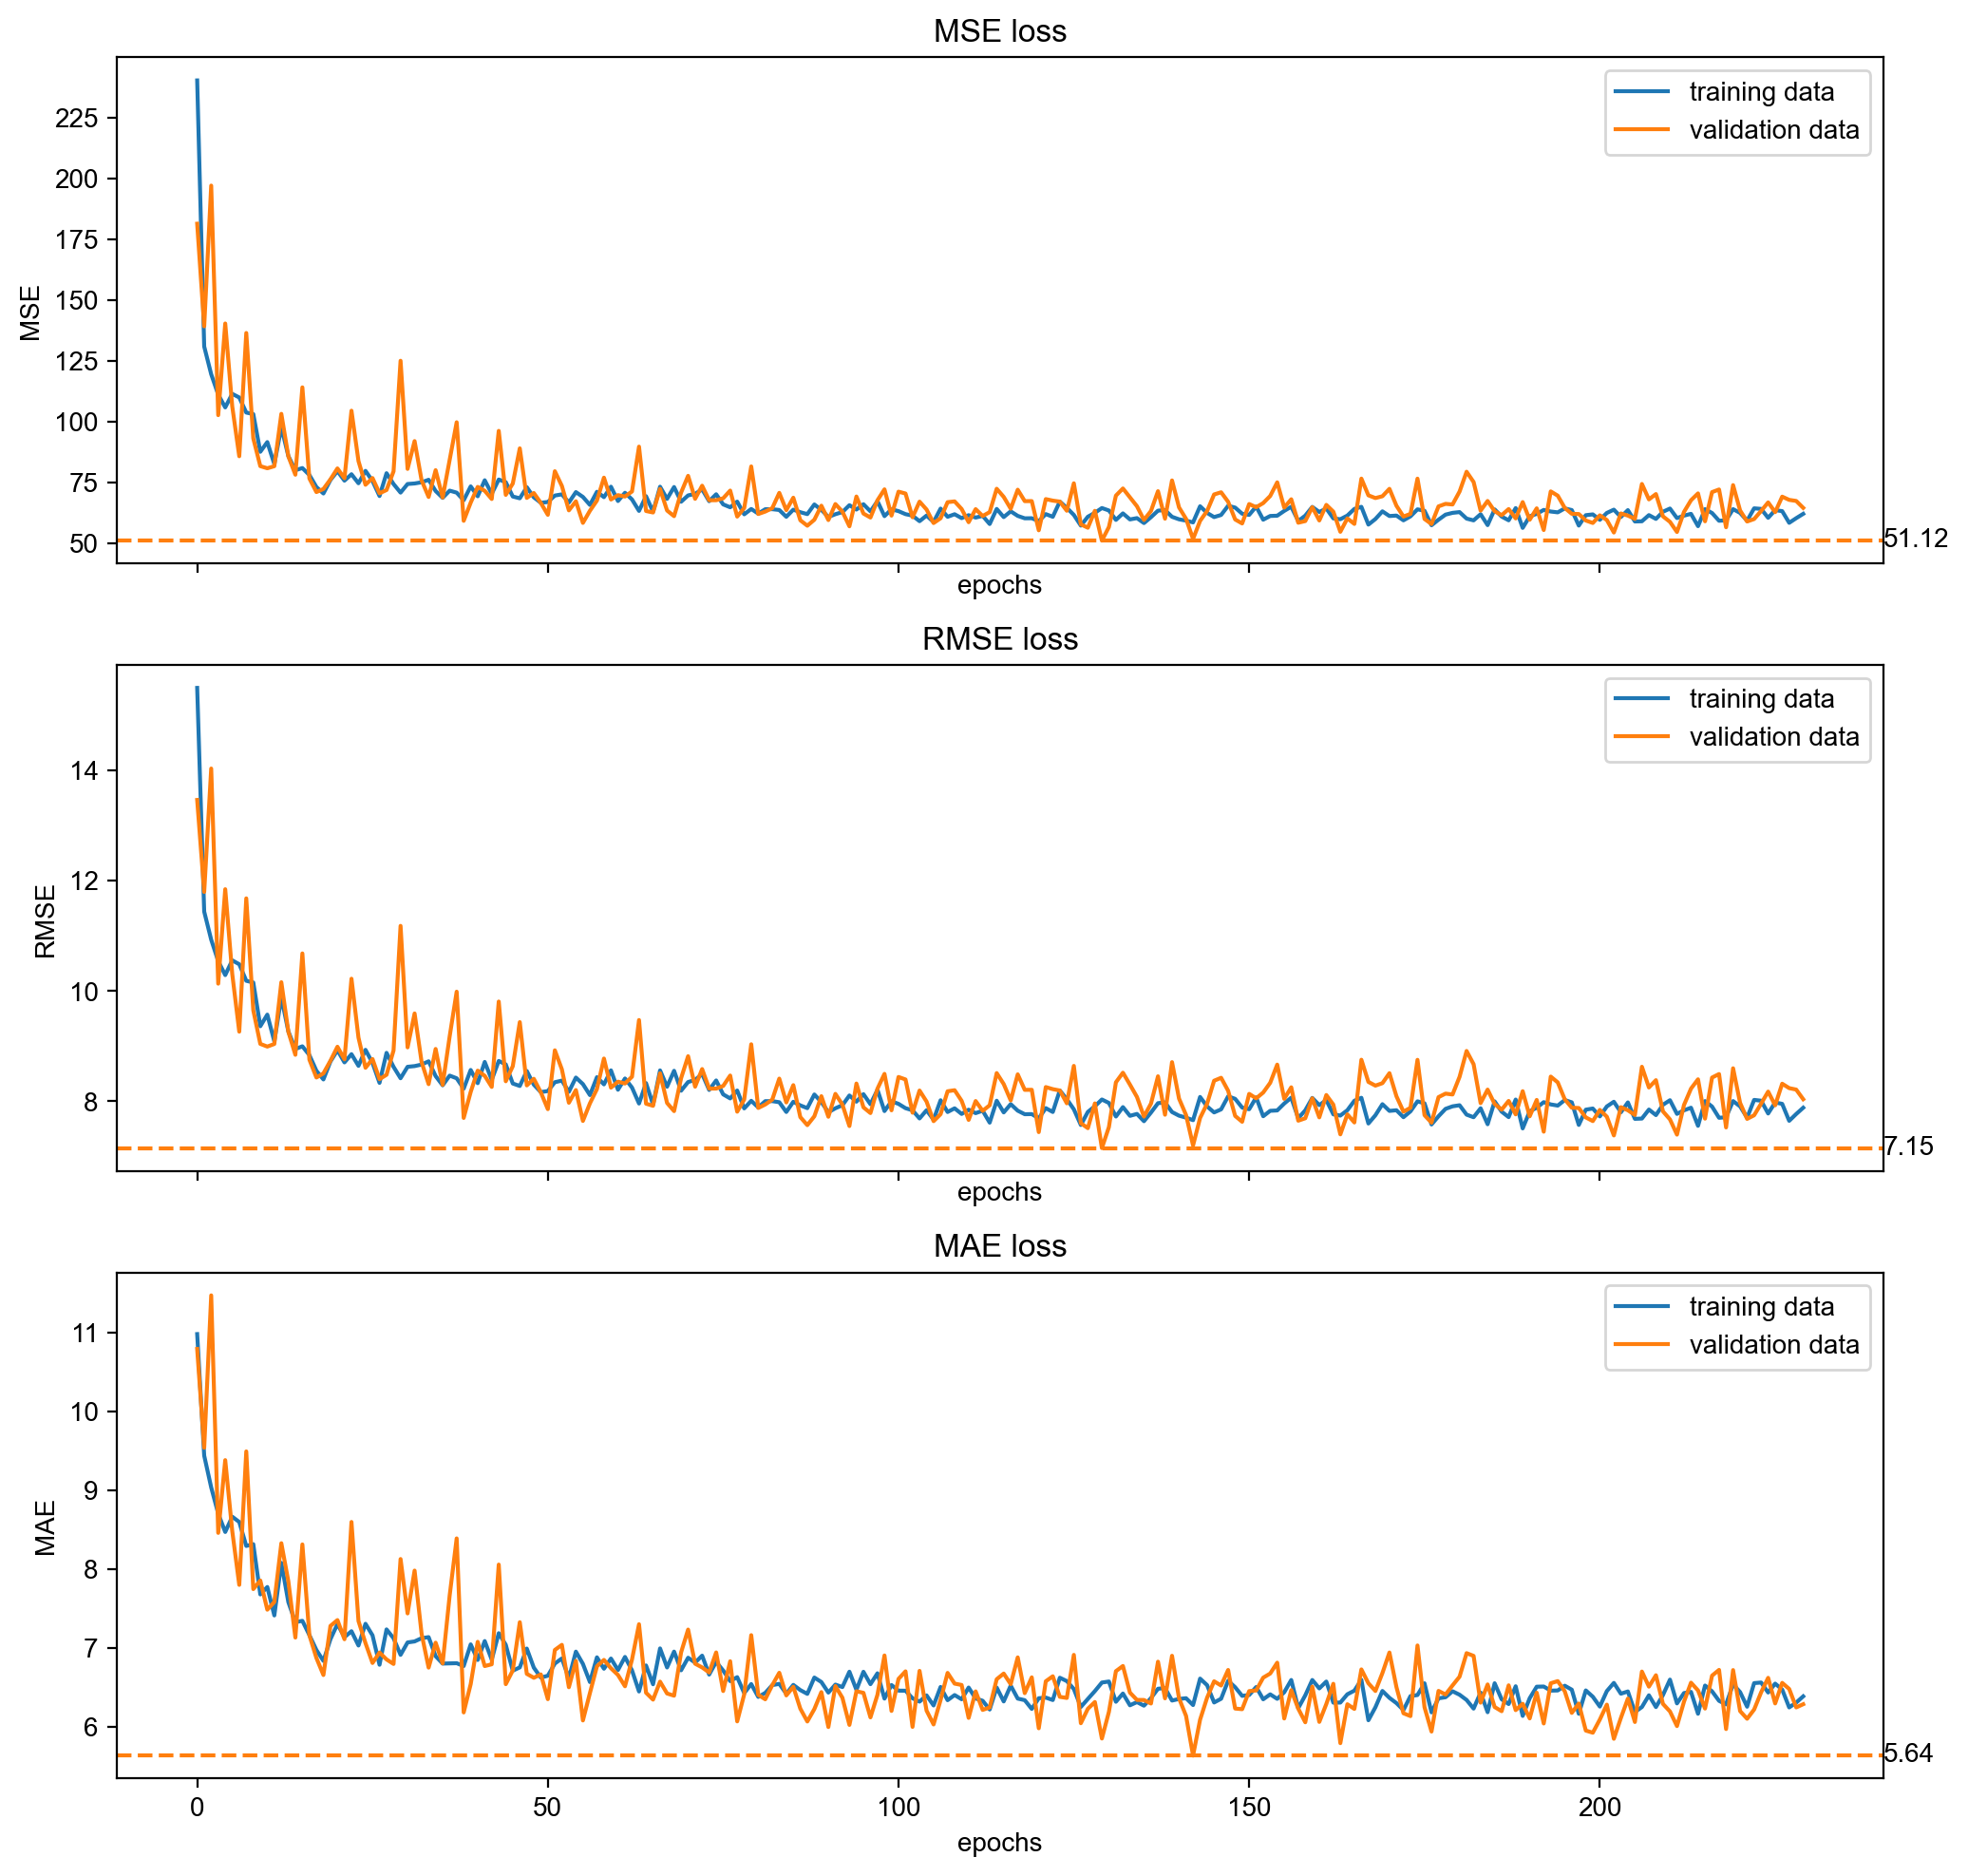

In [84]:
plot_loss(history)

# Testing of different architectures

Below we will test multiple different architectures, most of them as discussed in "Deep learning for time series classification: a review", by Ismail Fawaz et al (2019). Most of them are inspired again on other papers. Refer to the Ismail Fawaz paper for the original papers.

1. Fully-connected NN
2. CNN
3. ResNet
4. Encoder
5. Time-CNN
6. MCDCNN (Multi Channel Deep CNN)
7. MCNN (Multi-scale CNN)
8. t-LeNet

Other architectures to test:

- InceptionTime (Done above)
- BLSTM-LSTM 
- Echo State Network

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)

# 1. Fully connected NN

In [54]:
def fully_connected_model():
    """ Returns the fully connected model from Ismail Fawaz et al. (2019). """

    input_layer = keras.layers.Input(input_shape)

    input_layer_flattened = keras.layers.Flatten()(input_layer)

    layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
    layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

    layer_2 = keras.layers.Dropout(0.2)(layer_1)
    layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

    layer_3 = keras.layers.Dropout(0.2)(layer_2)
    layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

    output_layer = keras.layers.Dropout(0.3)(layer_3)
    output_layer = keras.layers.Dense(1)(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [56]:
model = fully_connected_model()

optimizer = Adadelta(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# 01 seems to be incorrect (makes too many predictions, changed model)
# Fully_connected_regressor_01: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
# Fully_connected_regressor_02: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
output_filename = 'Fully_connected_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0.0001, verbose=1)

In [57]:
%%time

epochs = 5000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/5000
143/143 [==============================] - 75s 518ms/step - loss: 686.5651 - root_mean_squared_error: 26.1876 - mean_absolute_error: 23.9677 - val_loss: 259.8801 - val_root_mean_squared_error: 16.1208 - val_mean_absolute_error: 13.0049

Epoch 00001: val_loss improved from inf to 259.88013, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_02.hdf5
Epoch 2/5000
143/143 [==============================] - 73s 510ms/step - loss: 249.2664 - root_mean_squared_error: 15.7816 - mean_absolute_error: 12.9082 - val_loss: 253.0222 - val_root_mean_squared_error: 15.9067 - val_mean_absolute_error: 12.9227

Epoch 00002: val_loss improved from 259.88013 to 253.02216, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_02.hdf5
Epoch 3/5000
143/143 [==============================] - 78s 546ms/step - loss: 225.3964 - root_mean_squared_error: 14.9978 - mean_absolu

143/143 [==============================] - 84s 590ms/step - loss: 100.3745 - root_mean_squared_error: 10.0127 - mean_absolute_error: 7.8999 - val_loss: 108.9902 - val_root_mean_squared_error: 10.4398 - val_mean_absolute_error: 8.3253

Epoch 00023: val_loss did not improve from 95.01680
Epoch 24/5000
143/143 [==============================] - 88s 613ms/step - loss: 102.4847 - root_mean_squared_error: 10.1189 - mean_absolute_error: 8.3211 - val_loss: 105.6531 - val_root_mean_squared_error: 10.2788 - val_mean_absolute_error: 8.2036

Epoch 00024: val_loss did not improve from 95.01680
Epoch 25/5000
143/143 [==============================] - 79s 552ms/step - loss: 107.6021 - root_mean_squared_error: 10.3706 - mean_absolute_error: 8.3028 - val_loss: 100.5498 - val_root_mean_squared_error: 10.0275 - val_mean_absolute_error: 7.9042

Epoch 00025: val_loss did not improve from 95.01680
Epoch 26/5000
143/143 [==============================] - 84s 591ms/step - loss: 102.0542 - root_mean_squared_er


Epoch 00048: val_loss did not improve from 74.86243
Epoch 49/5000
143/143 [==============================] - 84s 586ms/step - loss: 76.7939 - root_mean_squared_error: 8.7572 - mean_absolute_error: 6.9760 - val_loss: 93.6196 - val_root_mean_squared_error: 9.6757 - val_mean_absolute_error: 7.7446

Epoch 00049: val_loss did not improve from 74.86243
Epoch 50/5000
143/143 [==============================] - 82s 574ms/step - loss: 78.7939 - root_mean_squared_error: 8.8754 - mean_absolute_error: 7.0747 - val_loss: 97.1004 - val_root_mean_squared_error: 9.8540 - val_mean_absolute_error: 7.8694

Epoch 00050: val_loss did not improve from 74.86243
Epoch 51/5000
143/143 [==============================] - 86s 601ms/step - loss: 90.7031 - root_mean_squared_error: 9.5201 - mean_absolute_error: 7.6059 - val_loss: 86.2410 - val_root_mean_squared_error: 9.2866 - val_mean_absolute_error: 7.5162

Epoch 00051: val_loss did not improve from 74.86243
Epoch 52/5000
143/143 [==============================] -

143/143 [==============================] - 87s 611ms/step - loss: 78.0558 - root_mean_squared_error: 8.8217 - mean_absolute_error: 7.0758 - val_loss: 93.0638 - val_root_mean_squared_error: 9.6470 - val_mean_absolute_error: 7.7482

Epoch 00076: val_loss did not improve from 71.80109
Epoch 77/5000
143/143 [==============================] - 88s 613ms/step - loss: 73.3663 - root_mean_squared_error: 8.5597 - mean_absolute_error: 6.8716 - val_loss: 85.3306 - val_root_mean_squared_error: 9.2375 - val_mean_absolute_error: 7.2979

Epoch 00077: val_loss did not improve from 71.80109
Epoch 78/5000
143/143 [==============================] - 86s 604ms/step - loss: 74.1676 - root_mean_squared_error: 8.6090 - mean_absolute_error: 6.8200 - val_loss: 83.5317 - val_root_mean_squared_error: 9.1396 - val_mean_absolute_error: 7.0492

Epoch 00078: val_loss did not improve from 71.80109
Epoch 79/5000
143/143 [==============================] - 90s 629ms/step - loss: 68.6074 - root_mean_squared_error: 8.2761 -


Epoch 00102: val_loss did not improve from 67.61584
Epoch 103/5000
143/143 [==============================] - 86s 605ms/step - loss: 69.6976 - root_mean_squared_error: 8.3446 - mean_absolute_error: 6.7207 - val_loss: 92.6734 - val_root_mean_squared_error: 9.6267 - val_mean_absolute_error: 7.5846

Epoch 00103: val_loss did not improve from 67.61584
Epoch 104/5000
143/143 [==============================] - 83s 580ms/step - loss: 69.1335 - root_mean_squared_error: 8.3138 - mean_absolute_error: 6.6812 - val_loss: 80.4616 - val_root_mean_squared_error: 8.9700 - val_mean_absolute_error: 7.2019

Epoch 00104: val_loss did not improve from 67.61584
Epoch 105/5000
143/143 [==============================] - 82s 578ms/step - loss: 67.1300 - root_mean_squared_error: 8.1890 - mean_absolute_error: 6.6302 - val_loss: 66.6638 - val_root_mean_squared_error: 8.1648 - val_mean_absolute_error: 6.5136

Epoch 00105: val_loss improved from 67.61584 to 66.66382, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 87s 611ms/step - loss: 70.2896 - root_mean_squared_error: 8.3807 - mean_absolute_error: 6.7153 - val_loss: 59.6103 - val_root_mean_squared_error: 7.7208 - val_mean_absolute_error: 6.2026

Epoch 00129: val_loss improved from 63.27084 to 59.61026, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_02.hdf5
Epoch 130/5000
143/143 [==============================] - 90s 630ms/step - loss: 64.2436 - root_mean_squared_error: 8.0078 - mean_absolute_error: 6.3890 - val_loss: 68.9998 - val_root_mean_squared_error: 8.3066 - val_mean_absolute_error: 6.7401

Epoch 00130: val_loss did not improve from 59.61026
Epoch 131/5000
143/143 [==============================] - 87s 609ms/step - loss: 68.5409 - root_mean_squared_error: 8.2757 - mean_absolute_error: 6.6379 - val_loss: 74.7295 - val_root_mean_squared_error: 8.6446 - val_mean_absolute_error: 6.8204

Epoch 00131: val_loss did not improve from

143/143 [==============================] - 90s 628ms/step - loss: 59.5854 - root_mean_squared_error: 7.7050 - mean_absolute_error: 6.2353 - val_loss: 73.7108 - val_root_mean_squared_error: 8.5855 - val_mean_absolute_error: 6.8489

Epoch 00183: val_loss did not improve from 58.89797
Epoch 184/5000
143/143 [==============================] - 89s 620ms/step - loss: 66.3933 - root_mean_squared_error: 8.1448 - mean_absolute_error: 6.5571 - val_loss: 79.6414 - val_root_mean_squared_error: 8.9242 - val_mean_absolute_error: 6.9765

Epoch 00184: val_loss did not improve from 58.89797
Epoch 185/5000
143/143 [==============================] - 88s 615ms/step - loss: 62.5125 - root_mean_squared_error: 7.9023 - mean_absolute_error: 6.2648 - val_loss: 72.8409 - val_root_mean_squared_error: 8.5347 - val_mean_absolute_error: 6.6716

Epoch 00185: val_loss did not improve from 58.89797
Epoch 186/5000
143/143 [==============================] - 88s 619ms/step - loss: 66.4987 - root_mean_squared_error: 8.153

143/143 [==============================] - 88s 619ms/step - loss: 65.3240 - root_mean_squared_error: 8.0805 - mean_absolute_error: 6.5482 - val_loss: 64.4352 - val_root_mean_squared_error: 8.0272 - val_mean_absolute_error: 6.4108

Epoch 00237: val_loss did not improve from 57.35953
Epoch 238/5000
143/143 [==============================] - 85s 598ms/step - loss: 52.3627 - root_mean_squared_error: 7.2278 - mean_absolute_error: 5.7122 - val_loss: 77.5768 - val_root_mean_squared_error: 8.8078 - val_mean_absolute_error: 6.9391

Epoch 00238: val_loss did not improve from 57.35953
Epoch 239/5000
143/143 [==============================] - 89s 626ms/step - loss: 56.7464 - root_mean_squared_error: 7.5323 - mean_absolute_error: 5.9129 - val_loss: 80.7594 - val_root_mean_squared_error: 8.9866 - val_mean_absolute_error: 7.0934

Epoch 00239: val_loss did not improve from 57.35953
Epoch 240/5000
143/143 [==============================] - 90s 627ms/step - loss: 64.6095 - root_mean_squared_error: 8.034


Epoch 00264: val_loss did not improve from 57.35953
Epoch 265/5000
143/143 [==============================] - 90s 628ms/step - loss: 58.5282 - root_mean_squared_error: 7.6488 - mean_absolute_error: 6.1216 - val_loss: 84.5256 - val_root_mean_squared_error: 9.1938 - val_mean_absolute_error: 7.2186

Epoch 00265: val_loss did not improve from 57.35953
Epoch 266/5000
143/143 [==============================] - 89s 624ms/step - loss: 62.4466 - root_mean_squared_error: 7.8964 - mean_absolute_error: 6.3587 - val_loss: 74.6083 - val_root_mean_squared_error: 8.6376 - val_mean_absolute_error: 6.8732

Epoch 00266: val_loss did not improve from 57.35953
Epoch 267/5000
143/143 [==============================] - 89s 626ms/step - loss: 55.9238 - root_mean_squared_error: 7.4744 - mean_absolute_error: 5.9962 - val_loss: 72.1177 - val_root_mean_squared_error: 8.4922 - val_mean_absolute_error: 6.8872

Epoch 00267: val_loss did not improve from 57.35953
Epoch 268/5000
143/143 [=============================


Epoch 00319: val_loss did not improve from 57.35953
Epoch 320/5000
143/143 [==============================] - 88s 618ms/step - loss: 54.8232 - root_mean_squared_error: 7.4029 - mean_absolute_error: 5.8397 - val_loss: 82.9161 - val_root_mean_squared_error: 9.1058 - val_mean_absolute_error: 7.1374

Epoch 00320: val_loss did not improve from 57.35953
Epoch 321/5000
143/143 [==============================] - 89s 620ms/step - loss: 57.2094 - root_mean_squared_error: 7.5612 - mean_absolute_error: 6.0018 - val_loss: 66.4151 - val_root_mean_squared_error: 8.1495 - val_mean_absolute_error: 6.3573

Epoch 00321: val_loss did not improve from 57.35953
Epoch 322/5000
143/143 [==============================] - 88s 616ms/step - loss: 57.0807 - root_mean_squared_error: 7.5528 - mean_absolute_error: 6.0488 - val_loss: 71.0496 - val_root_mean_squared_error: 8.4291 - val_mean_absolute_error: 6.7651

Epoch 00322: val_loss did not improve from 57.35953
Epoch 323/5000
143/143 [=============================

143/143 [==============================] - 91s 637ms/step - loss: 52.5518 - root_mean_squared_error: 7.2436 - mean_absolute_error: 5.7148 - val_loss: 68.3821 - val_root_mean_squared_error: 8.2693 - val_mean_absolute_error: 6.5896

Epoch 00347: val_loss did not improve from 54.34619
Epoch 348/5000
143/143 [==============================] - 90s 631ms/step - loss: 57.4519 - root_mean_squared_error: 7.5760 - mean_absolute_error: 5.9761 - val_loss: 60.9966 - val_root_mean_squared_error: 7.8100 - val_mean_absolute_error: 6.0712

Epoch 00348: val_loss did not improve from 54.34619
Epoch 349/5000
143/143 [==============================] - 89s 626ms/step - loss: 52.3261 - root_mean_squared_error: 7.2323 - mean_absolute_error: 5.7409 - val_loss: 67.4182 - val_root_mean_squared_error: 8.2109 - val_mean_absolute_error: 6.4361

Epoch 00349: val_loss did not improve from 54.34619
Epoch 350/5000
143/143 [==============================] - 89s 626ms/step - loss: 55.1368 - root_mean_squared_error: 7.422


Epoch 00374: val_loss did not improve from 54.34619
Epoch 375/5000
143/143 [==============================] - 92s 642ms/step - loss: 49.8089 - root_mean_squared_error: 7.0523 - mean_absolute_error: 5.6407 - val_loss: 57.9635 - val_root_mean_squared_error: 7.6134 - val_mean_absolute_error: 5.9232

Epoch 00375: val_loss did not improve from 54.34619
Epoch 376/5000
143/143 [==============================] - 91s 638ms/step - loss: 52.0097 - root_mean_squared_error: 7.1985 - mean_absolute_error: 5.7146 - val_loss: 74.4804 - val_root_mean_squared_error: 8.6302 - val_mean_absolute_error: 6.7386

Epoch 00376: val_loss did not improve from 54.34619
Epoch 377/5000
143/143 [==============================] - 91s 635ms/step - loss: 56.8746 - root_mean_squared_error: 7.5401 - mean_absolute_error: 6.0769 - val_loss: 64.6180 - val_root_mean_squared_error: 8.0385 - val_mean_absolute_error: 6.4424

Epoch 00377: val_loss did not improve from 54.34619
Epoch 378/5000
143/143 [=============================


Epoch 00429: val_loss did not improve from 54.34619
Epoch 430/5000
143/143 [==============================] - 90s 633ms/step - loss: 48.7867 - root_mean_squared_error: 6.9740 - mean_absolute_error: 5.5980 - val_loss: 65.5420 - val_root_mean_squared_error: 8.0958 - val_mean_absolute_error: 6.1701

Epoch 00430: val_loss did not improve from 54.34619
Epoch 431/5000
143/143 [==============================] - 91s 634ms/step - loss: 50.5543 - root_mean_squared_error: 7.1085 - mean_absolute_error: 5.7452 - val_loss: 65.9187 - val_root_mean_squared_error: 8.1190 - val_mean_absolute_error: 6.2628

Epoch 00431: val_loss did not improve from 54.34619
Epoch 432/5000
143/143 [==============================] - 86s 604ms/step - loss: 51.2325 - root_mean_squared_error: 7.1521 - mean_absolute_error: 5.7254 - val_loss: 71.8589 - val_root_mean_squared_error: 8.4770 - val_mean_absolute_error: 6.4414

Epoch 00432: val_loss did not improve from 54.34619
Epoch 433/5000
143/143 [=============================


Epoch 00484: val_loss did not improve from 54.34619
Epoch 485/5000
143/143 [==============================] - 89s 627ms/step - loss: 45.5938 - root_mean_squared_error: 6.7389 - mean_absolute_error: 5.3689 - val_loss: 64.2881 - val_root_mean_squared_error: 8.0180 - val_mean_absolute_error: 6.3721

Epoch 00485: val_loss did not improve from 54.34619
Epoch 486/5000
143/143 [==============================] - 88s 616ms/step - loss: 51.5641 - root_mean_squared_error: 7.1734 - mean_absolute_error: 5.6147 - val_loss: 71.6766 - val_root_mean_squared_error: 8.4662 - val_mean_absolute_error: 6.5295

Epoch 00486: val_loss did not improve from 54.34619
Epoch 487/5000
143/143 [==============================] - 90s 628ms/step - loss: 46.8292 - root_mean_squared_error: 6.8361 - mean_absolute_error: 5.4702 - val_loss: 72.6248 - val_root_mean_squared_error: 8.5220 - val_mean_absolute_error: 6.8345

Epoch 00487: val_loss did not improve from 54.34619
Epoch 488/5000
143/143 [=============================

143/143 [==============================] - 89s 626ms/step - loss: 49.9393 - root_mean_squared_error: 7.0657 - mean_absolute_error: 5.6264 - val_loss: 70.6379 - val_root_mean_squared_error: 8.4046 - val_mean_absolute_error: 6.4766

Epoch 00539: val_loss did not improve from 54.34619
Epoch 540/5000
143/143 [==============================] - 89s 624ms/step - loss: 56.9436 - root_mean_squared_error: 7.5237 - mean_absolute_error: 5.8562 - val_loss: 71.2239 - val_root_mean_squared_error: 8.4394 - val_mean_absolute_error: 6.7409

Epoch 00540: val_loss did not improve from 54.34619
Epoch 541/5000
143/143 [==============================] - 90s 631ms/step - loss: 49.3894 - root_mean_squared_error: 7.0262 - mean_absolute_error: 5.5626 - val_loss: 70.1659 - val_root_mean_squared_error: 8.3765 - val_mean_absolute_error: 6.4617

Epoch 00541: val_loss did not improve from 54.34619
Epoch 542/5000
143/143 [==============================] - 90s 629ms/step - loss: 49.1274 - root_mean_squared_error: 7.001


Epoch 00566: val_loss did not improve from 54.34619
Epoch 567/5000
143/143 [==============================] - 87s 610ms/step - loss: 46.6684 - root_mean_squared_error: 6.8243 - mean_absolute_error: 5.3382 - val_loss: 61.4268 - val_root_mean_squared_error: 7.8375 - val_mean_absolute_error: 6.1993

Epoch 00567: val_loss did not improve from 54.34619
Epoch 568/5000
143/143 [==============================] - 88s 617ms/step - loss: 49.4823 - root_mean_squared_error: 7.0331 - mean_absolute_error: 5.6187 - val_loss: 70.1117 - val_root_mean_squared_error: 8.3733 - val_mean_absolute_error: 6.5842

Epoch 00568: val_loss did not improve from 54.34619
Epoch 569/5000
143/143 [==============================] - 90s 628ms/step - loss: 49.0246 - root_mean_squared_error: 6.9999 - mean_absolute_error: 5.6006 - val_loss: 64.9224 - val_root_mean_squared_error: 8.0574 - val_mean_absolute_error: 6.2157

Epoch 00569: val_loss did not improve from 54.34619
Epoch 570/5000
143/143 [=============================


Epoch 00621: val_loss did not improve from 54.34619
Epoch 622/5000
143/143 [==============================] - 89s 620ms/step - loss: 54.6515 - root_mean_squared_error: 7.3875 - mean_absolute_error: 5.7768 - val_loss: 63.1079 - val_root_mean_squared_error: 7.9440 - val_mean_absolute_error: 6.1812

Epoch 00622: val_loss did not improve from 54.34619
Epoch 623/5000
143/143 [==============================] - 89s 626ms/step - loss: 50.7823 - root_mean_squared_error: 7.1241 - mean_absolute_error: 5.6508 - val_loss: 69.8464 - val_root_mean_squared_error: 8.3574 - val_mean_absolute_error: 6.4389

Epoch 00623: val_loss did not improve from 54.34619
Epoch 624/5000
143/143 [==============================] - 92s 644ms/step - loss: 48.1340 - root_mean_squared_error: 6.9352 - mean_absolute_error: 5.5100 - val_loss: 63.6904 - val_root_mean_squared_error: 7.9806 - val_mean_absolute_error: 6.3621

Epoch 00624: val_loss did not improve from 54.34619
Epoch 625/5000
143/143 [=============================


Epoch 00676: val_loss did not improve from 54.34619
Epoch 677/5000
143/143 [==============================] - 89s 620ms/step - loss: 48.1293 - root_mean_squared_error: 6.9360 - mean_absolute_error: 5.4779 - val_loss: 73.1832 - val_root_mean_squared_error: 8.5547 - val_mean_absolute_error: 6.6884

Epoch 00677: val_loss did not improve from 54.34619
Epoch 678/5000
143/143 [==============================] - 89s 622ms/step - loss: 43.7036 - root_mean_squared_error: 6.6091 - mean_absolute_error: 5.3298 - val_loss: 53.7418 - val_root_mean_squared_error: 7.3309 - val_mean_absolute_error: 5.8346

Epoch 00678: val_loss improved from 54.34619 to 53.74181, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_02.hdf5
Epoch 679/5000
143/143 [==============================] - 88s 617ms/step - loss: 43.3471 - root_mean_squared_error: 6.5822 - mean_absolute_error: 5.3199 - val_loss: 77.3020 - val_root_mean_squared_error: 8.7922 - val_mea

143/143 [==============================] - 88s 613ms/step - loss: 47.6682 - root_mean_squared_error: 6.8985 - mean_absolute_error: 5.4257 - val_loss: 69.4840 - val_root_mean_squared_error: 8.3357 - val_mean_absolute_error: 6.2784

Epoch 00704: val_loss did not improve from 53.74181
Epoch 705/5000
143/143 [==============================] - 88s 614ms/step - loss: 47.7099 - root_mean_squared_error: 6.9048 - mean_absolute_error: 5.4926 - val_loss: 67.2027 - val_root_mean_squared_error: 8.1977 - val_mean_absolute_error: 6.4732

Epoch 00705: val_loss did not improve from 53.74181
Epoch 706/5000
143/143 [==============================] - 88s 617ms/step - loss: 41.7802 - root_mean_squared_error: 6.4605 - mean_absolute_error: 5.0968 - val_loss: 72.5221 - val_root_mean_squared_error: 8.5160 - val_mean_absolute_error: 6.9576

Epoch 00706: val_loss did not improve from 53.74181
Epoch 707/5000
143/143 [==============================] - 88s 616ms/step - loss: 47.4884 - root_mean_squared_error: 6.888


Epoch 00731: val_loss did not improve from 53.74181
Epoch 732/5000
143/143 [==============================] - 91s 637ms/step - loss: 47.2952 - root_mean_squared_error: 6.8724 - mean_absolute_error: 5.4554 - val_loss: 75.6656 - val_root_mean_squared_error: 8.6986 - val_mean_absolute_error: 6.7715

Epoch 00732: val_loss did not improve from 53.74181
Epoch 733/5000
143/143 [==============================] - 92s 645ms/step - loss: 49.2472 - root_mean_squared_error: 7.0164 - mean_absolute_error: 5.5530 - val_loss: 67.6592 - val_root_mean_squared_error: 8.2255 - val_mean_absolute_error: 6.4215

Epoch 00733: val_loss did not improve from 53.74181
Epoch 734/5000
143/143 [==============================] - 91s 638ms/step - loss: 46.5934 - root_mean_squared_error: 6.8158 - mean_absolute_error: 5.3138 - val_loss: 61.2914 - val_root_mean_squared_error: 7.8289 - val_mean_absolute_error: 6.1578

Epoch 00734: val_loss did not improve from 53.74181
Epoch 735/5000
143/143 [=============================


Epoch 00785: val_loss did not improve from 51.34325
Epoch 786/5000
143/143 [==============================] - 81s 569ms/step - loss: 46.9591 - root_mean_squared_error: 6.8484 - mean_absolute_error: 5.3649 - val_loss: 59.3127 - val_root_mean_squared_error: 7.7015 - val_mean_absolute_error: 6.2575

Epoch 00786: val_loss did not improve from 51.34325
Epoch 787/5000
143/143 [==============================] - 83s 581ms/step - loss: 51.2733 - root_mean_squared_error: 7.1514 - mean_absolute_error: 5.5966 - val_loss: 76.6286 - val_root_mean_squared_error: 8.7538 - val_mean_absolute_error: 6.8095

Epoch 00787: val_loss did not improve from 51.34325
Epoch 788/5000
143/143 [==============================] - 92s 643ms/step - loss: 46.9977 - root_mean_squared_error: 6.8504 - mean_absolute_error: 5.3860 - val_loss: 65.8771 - val_root_mean_squared_error: 8.1165 - val_mean_absolute_error: 6.5081

Epoch 00788: val_loss did not improve from 51.34325
Epoch 789/5000
143/143 [=============================


Epoch 00840: val_loss did not improve from 51.34325
Epoch 841/5000
143/143 [==============================] - 91s 638ms/step - loss: 47.2504 - root_mean_squared_error: 6.8731 - mean_absolute_error: 5.5259 - val_loss: 64.5632 - val_root_mean_squared_error: 8.0351 - val_mean_absolute_error: 6.2158

Epoch 00841: val_loss did not improve from 51.34325
Epoch 842/5000
143/143 [==============================] - 88s 619ms/step - loss: 47.5516 - root_mean_squared_error: 6.8923 - mean_absolute_error: 5.3414 - val_loss: 69.2634 - val_root_mean_squared_error: 8.3225 - val_mean_absolute_error: 6.5879

Epoch 00842: val_loss did not improve from 51.34325
Epoch 843/5000
143/143 [==============================] - 90s 628ms/step - loss: 47.9892 - root_mean_squared_error: 6.9204 - mean_absolute_error: 5.4759 - val_loss: 60.7955 - val_root_mean_squared_error: 7.7971 - val_mean_absolute_error: 5.9966

Epoch 00843: val_loss did not improve from 51.34325
Epoch 844/5000
143/143 [=============================


Epoch 00895: val_loss did not improve from 51.34325
Epoch 896/5000
143/143 [==============================] - 86s 601ms/step - loss: 39.8463 - root_mean_squared_error: 6.3078 - mean_absolute_error: 5.0396 - val_loss: 64.3899 - val_root_mean_squared_error: 8.0243 - val_mean_absolute_error: 6.3542

Epoch 00896: val_loss did not improve from 51.34325
Epoch 897/5000
143/143 [==============================] - 86s 600ms/step - loss: 46.1355 - root_mean_squared_error: 6.7891 - mean_absolute_error: 5.2805 - val_loss: 59.6286 - val_root_mean_squared_error: 7.7220 - val_mean_absolute_error: 6.0148

Epoch 00897: val_loss did not improve from 51.34325
Epoch 898/5000
143/143 [==============================] - 85s 598ms/step - loss: 47.6652 - root_mean_squared_error: 6.8991 - mean_absolute_error: 5.4779 - val_loss: 67.5971 - val_root_mean_squared_error: 8.2217 - val_mean_absolute_error: 6.5025

Epoch 00898: val_loss did not improve from 51.34325
Epoch 899/5000
143/143 [=============================


Epoch 00950: val_loss did not improve from 51.34325
Epoch 951/5000
143/143 [==============================] - 90s 630ms/step - loss: 42.6627 - root_mean_squared_error: 6.5282 - mean_absolute_error: 5.1288 - val_loss: 68.1627 - val_root_mean_squared_error: 8.2561 - val_mean_absolute_error: 6.4429

Epoch 00951: val_loss did not improve from 51.34325
Epoch 952/5000
143/143 [==============================] - 91s 640ms/step - loss: 43.3774 - root_mean_squared_error: 6.5809 - mean_absolute_error: 5.3155 - val_loss: 66.6346 - val_root_mean_squared_error: 8.1630 - val_mean_absolute_error: 6.4566

Epoch 00952: val_loss did not improve from 51.34325
Epoch 953/5000
143/143 [==============================] - 90s 630ms/step - loss: 43.0342 - root_mean_squared_error: 6.5573 - mean_absolute_error: 5.1518 - val_loss: 69.5158 - val_root_mean_squared_error: 8.3376 - val_mean_absolute_error: 6.7894

Epoch 00953: val_loss did not improve from 51.34325
Epoch 954/5000
143/143 [=============================

143/143 [==============================] - 91s 639ms/step - loss: 44.0685 - root_mean_squared_error: 6.6376 - mean_absolute_error: 5.2544 - val_loss: 84.1595 - val_root_mean_squared_error: 9.1739 - val_mean_absolute_error: 7.1764

Epoch 00978: val_loss did not improve from 51.34325
Epoch 979/5000
143/143 [==============================] - 90s 633ms/step - loss: 45.8164 - root_mean_squared_error: 6.7617 - mean_absolute_error: 5.2640 - val_loss: 72.7866 - val_root_mean_squared_error: 8.5315 - val_mean_absolute_error: 6.6214

Epoch 00979: val_loss did not improve from 51.34325
Epoch 980/5000
143/143 [==============================] - 89s 625ms/step - loss: 47.3712 - root_mean_squared_error: 6.8805 - mean_absolute_error: 5.4798 - val_loss: 69.4194 - val_root_mean_squared_error: 8.3318 - val_mean_absolute_error: 6.4713

Epoch 00980: val_loss did not improve from 51.34325
Epoch 981/5000
143/143 [==============================] - 90s 629ms/step - loss: 46.8912 - root_mean_squared_error: 6.843


Epoch 01005: val_loss did not improve from 51.34325
Epoch 1006/5000
143/143 [==============================] - 82s 576ms/step - loss: 46.4546 - root_mean_squared_error: 6.8125 - mean_absolute_error: 5.4992 - val_loss: 67.4131 - val_root_mean_squared_error: 8.2106 - val_mean_absolute_error: 6.3196

Epoch 01006: val_loss did not improve from 51.34325
Epoch 1007/5000
143/143 [==============================] - 85s 596ms/step - loss: 47.0525 - root_mean_squared_error: 6.8460 - mean_absolute_error: 5.3775 - val_loss: 73.1848 - val_root_mean_squared_error: 8.5548 - val_mean_absolute_error: 6.7082

Epoch 01007: val_loss did not improve from 51.34325
Epoch 1008/5000
143/143 [==============================] - 86s 603ms/step - loss: 48.8205 - root_mean_squared_error: 6.9853 - mean_absolute_error: 5.5360 - val_loss: 68.6729 - val_root_mean_squared_error: 8.2869 - val_mean_absolute_error: 6.5097

Epoch 01008: val_loss did not improve from 51.34325
Epoch 1009/5000
143/143 [=========================

143/143 [==============================] - 89s 621ms/step - loss: 43.9217 - root_mean_squared_error: 6.6263 - mean_absolute_error: 5.1758 - val_loss: 71.7955 - val_root_mean_squared_error: 8.4732 - val_mean_absolute_error: 6.6232

Epoch 01060: val_loss did not improve from 51.34325
Epoch 1061/5000
143/143 [==============================] - 90s 628ms/step - loss: 43.6736 - root_mean_squared_error: 6.6062 - mean_absolute_error: 5.1905 - val_loss: 66.1298 - val_root_mean_squared_error: 8.1320 - val_mean_absolute_error: 6.4589

Epoch 01061: val_loss did not improve from 51.34325
Epoch 1062/5000
143/143 [==============================] - 90s 629ms/step - loss: 46.8427 - root_mean_squared_error: 6.8424 - mean_absolute_error: 5.5067 - val_loss: 72.9154 - val_root_mean_squared_error: 8.5390 - val_mean_absolute_error: 6.6200

Epoch 01062: val_loss did not improve from 51.34325
Epoch 1063/5000
143/143 [==============================] - 90s 632ms/step - loss: 46.5381 - root_mean_squared_error: 6.

143/143 [==============================] - 90s 627ms/step - loss: 41.5317 - root_mean_squared_error: 6.4398 - mean_absolute_error: 5.1038 - val_loss: 75.7640 - val_root_mean_squared_error: 8.7043 - val_mean_absolute_error: 6.9109

Epoch 01114: val_loss did not improve from 51.34325
Epoch 1115/5000
143/143 [==============================] - 91s 636ms/step - loss: 44.7271 - root_mean_squared_error: 6.6831 - mean_absolute_error: 5.3210 - val_loss: 84.0814 - val_root_mean_squared_error: 9.1696 - val_mean_absolute_error: 7.1625

Epoch 01115: val_loss did not improve from 51.34325
Epoch 1116/5000
143/143 [==============================] - 89s 626ms/step - loss: 47.4961 - root_mean_squared_error: 6.8878 - mean_absolute_error: 5.3956 - val_loss: 67.0748 - val_root_mean_squared_error: 8.1899 - val_mean_absolute_error: 6.4762

Epoch 01116: val_loss did not improve from 51.34325
Epoch 1117/5000
143/143 [==============================] - 88s 617ms/step - loss: 42.7069 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 615ms/step - loss: 41.5136 - root_mean_squared_error: 6.4392 - mean_absolute_error: 5.0513 - val_loss: 58.2169 - val_root_mean_squared_error: 7.6300 - val_mean_absolute_error: 5.8878

Epoch 01168: val_loss did not improve from 50.98401
Epoch 1169/5000
143/143 [==============================] - 90s 627ms/step - loss: 40.2523 - root_mean_squared_error: 6.3347 - mean_absolute_error: 5.0504 - val_loss: 73.1188 - val_root_mean_squared_error: 8.5510 - val_mean_absolute_error: 6.6939

Epoch 01169: val_loss did not improve from 50.98401
Epoch 1170/5000
143/143 [==============================] - 91s 638ms/step - loss: 47.8813 - root_mean_squared_error: 6.9158 - mean_absolute_error: 5.3119 - val_loss: 62.1341 - val_root_mean_squared_error: 7.8825 - val_mean_absolute_error: 6.1879

Epoch 01170: val_loss did not improve from 50.98401
Epoch 1171/5000
143/143 [==============================] - 87s 612ms/step - loss: 47.4659 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 616ms/step - loss: 47.6161 - root_mean_squared_error: 6.8982 - mean_absolute_error: 5.3890 - val_loss: 56.9699 - val_root_mean_squared_error: 7.5478 - val_mean_absolute_error: 6.0654

Epoch 01222: val_loss did not improve from 50.98401
Epoch 1223/5000
143/143 [==============================] - 91s 638ms/step - loss: 46.2273 - root_mean_squared_error: 6.7942 - mean_absolute_error: 5.3600 - val_loss: 65.3632 - val_root_mean_squared_error: 8.0848 - val_mean_absolute_error: 6.2989

Epoch 01223: val_loss did not improve from 50.98401
Epoch 1224/5000
143/143 [==============================] - 90s 633ms/step - loss: 44.2788 - root_mean_squared_error: 6.6521 - mean_absolute_error: 5.2675 - val_loss: 65.3347 - val_root_mean_squared_error: 8.0830 - val_mean_absolute_error: 6.3172

Epoch 01224: val_loss did not improve from 50.98401
Epoch 1225/5000
143/143 [==============================] - 90s 629ms/step - loss: 45.9419 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 622ms/step - loss: 42.1771 - root_mean_squared_error: 6.4915 - mean_absolute_error: 5.1028 - val_loss: 77.9825 - val_root_mean_squared_error: 8.8308 - val_mean_absolute_error: 6.7967

Epoch 01276: val_loss did not improve from 50.98401
Epoch 1277/5000
143/143 [==============================] - 89s 623ms/step - loss: 39.7882 - root_mean_squared_error: 6.2962 - mean_absolute_error: 5.0187 - val_loss: 56.6030 - val_root_mean_squared_error: 7.5235 - val_mean_absolute_error: 5.9249

Epoch 01277: val_loss did not improve from 50.98401
Epoch 1278/5000
143/143 [==============================] - 87s 610ms/step - loss: 45.7455 - root_mean_squared_error: 6.7614 - mean_absolute_error: 5.3402 - val_loss: 66.9717 - val_root_mean_squared_error: 8.1836 - val_mean_absolute_error: 6.5863

Epoch 01278: val_loss did not improve from 50.98401
Epoch 1279/5000
143/143 [==============================] - 89s 626ms/step - loss: 44.7488 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 625ms/step - loss: 45.7061 - root_mean_squared_error: 6.7560 - mean_absolute_error: 5.2513 - val_loss: 65.2985 - val_root_mean_squared_error: 8.0808 - val_mean_absolute_error: 6.2689

Epoch 01330: val_loss did not improve from 50.98401
Epoch 1331/5000
143/143 [==============================] - 90s 631ms/step - loss: 42.5371 - root_mean_squared_error: 6.5119 - mean_absolute_error: 5.1384 - val_loss: 73.1753 - val_root_mean_squared_error: 8.5543 - val_mean_absolute_error: 6.5893

Epoch 01331: val_loss did not improve from 50.98401
Epoch 1332/5000
143/143 [==============================] - 88s 618ms/step - loss: 43.8256 - root_mean_squared_error: 6.6093 - mean_absolute_error: 5.2452 - val_loss: 68.9131 - val_root_mean_squared_error: 8.3014 - val_mean_absolute_error: 6.4205

Epoch 01332: val_loss did not improve from 50.98401
Epoch 1333/5000
143/143 [==============================] - 84s 590ms/step - loss: 43.0532 - root_mean_squared_error: 6.

143/143 [==============================] - 85s 592ms/step - loss: 39.4296 - root_mean_squared_error: 6.2763 - mean_absolute_error: 4.8601 - val_loss: 62.9173 - val_root_mean_squared_error: 7.9320 - val_mean_absolute_error: 6.0267

Epoch 01357: val_loss did not improve from 49.59538
Epoch 1358/5000
143/143 [==============================] - 85s 593ms/step - loss: 44.8423 - root_mean_squared_error: 6.6923 - mean_absolute_error: 5.2166 - val_loss: 62.6477 - val_root_mean_squared_error: 7.9150 - val_mean_absolute_error: 6.1593

Epoch 01358: val_loss did not improve from 49.59538
Epoch 1359/5000
143/143 [==============================] - 89s 621ms/step - loss: 45.5447 - root_mean_squared_error: 6.7469 - mean_absolute_error: 5.3732 - val_loss: 72.2329 - val_root_mean_squared_error: 8.4990 - val_mean_absolute_error: 6.5837

Epoch 01359: val_loss did not improve from 49.59538
Epoch 1360/5000
143/143 [==============================] - 87s 612ms/step - loss: 37.9687 - root_mean_squared_error: 6.

143/143 [==============================] - 91s 637ms/step - loss: 42.0652 - root_mean_squared_error: 6.4846 - mean_absolute_error: 5.0777 - val_loss: 61.3463 - val_root_mean_squared_error: 7.8324 - val_mean_absolute_error: 6.1549

Epoch 01411: val_loss did not improve from 49.59538
Epoch 1412/5000
143/143 [==============================] - 90s 631ms/step - loss: 44.1573 - root_mean_squared_error: 6.6390 - mean_absolute_error: 5.1648 - val_loss: 70.5161 - val_root_mean_squared_error: 8.3974 - val_mean_absolute_error: 6.5094

Epoch 01412: val_loss did not improve from 49.59538
Epoch 1413/5000
143/143 [==============================] - 89s 624ms/step - loss: 42.4186 - root_mean_squared_error: 6.5080 - mean_absolute_error: 5.0626 - val_loss: 55.8842 - val_root_mean_squared_error: 7.4756 - val_mean_absolute_error: 5.8729

Epoch 01413: val_loss did not improve from 49.59538
Epoch 1414/5000
143/143 [==============================] - 88s 615ms/step - loss: 42.4855 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 621ms/step - loss: 41.0604 - root_mean_squared_error: 6.4054 - mean_absolute_error: 5.0056 - val_loss: 59.9748 - val_root_mean_squared_error: 7.7443 - val_mean_absolute_error: 6.2635

Epoch 01465: val_loss did not improve from 49.59538
Epoch 1466/5000
143/143 [==============================] - 90s 627ms/step - loss: 46.3492 - root_mean_squared_error: 6.8071 - mean_absolute_error: 5.3701 - val_loss: 68.8490 - val_root_mean_squared_error: 8.2975 - val_mean_absolute_error: 6.4214

Epoch 01466: val_loss did not improve from 49.59538
Epoch 1467/5000
143/143 [==============================] - 89s 621ms/step - loss: 44.5693 - root_mean_squared_error: 6.6753 - mean_absolute_error: 5.2072 - val_loss: 84.5752 - val_root_mean_squared_error: 9.1965 - val_mean_absolute_error: 7.0683

Epoch 01467: val_loss did not improve from 49.59538
Epoch 1468/5000
143/143 [==============================] - 89s 623ms/step - loss: 42.0100 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 618ms/step - loss: 43.2628 - root_mean_squared_error: 6.5749 - mean_absolute_error: 5.1524 - val_loss: 58.4029 - val_root_mean_squared_error: 7.6422 - val_mean_absolute_error: 5.8313

Epoch 01519: val_loss did not improve from 47.66341
Epoch 1520/5000
143/143 [==============================] - 88s 614ms/step - loss: 40.3903 - root_mean_squared_error: 6.3519 - mean_absolute_error: 5.0352 - val_loss: 62.5630 - val_root_mean_squared_error: 7.9097 - val_mean_absolute_error: 6.2143

Epoch 01520: val_loss did not improve from 47.66341
Epoch 1521/5000
143/143 [==============================] - 88s 618ms/step - loss: 41.3089 - root_mean_squared_error: 6.4245 - mean_absolute_error: 5.1109 - val_loss: 68.0083 - val_root_mean_squared_error: 8.2467 - val_mean_absolute_error: 6.4354

Epoch 01521: val_loss did not improve from 47.66341
Epoch 1522/5000
143/143 [==============================] - 89s 626ms/step - loss: 40.4234 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 627ms/step - loss: 44.9323 - root_mean_squared_error: 6.6969 - mean_absolute_error: 5.2610 - val_loss: 58.1721 - val_root_mean_squared_error: 7.6271 - val_mean_absolute_error: 5.8442

Epoch 01573: val_loss did not improve from 47.66341
Epoch 1574/5000
143/143 [==============================] - 91s 635ms/step - loss: 42.6241 - root_mean_squared_error: 6.5269 - mean_absolute_error: 5.1863 - val_loss: 67.6841 - val_root_mean_squared_error: 8.2270 - val_mean_absolute_error: 6.4952

Epoch 01574: val_loss did not improve from 47.66341
Epoch 1575/5000
143/143 [==============================] - 89s 622ms/step - loss: 38.1423 - root_mean_squared_error: 6.1692 - mean_absolute_error: 4.8489 - val_loss: 63.6769 - val_root_mean_squared_error: 7.9798 - val_mean_absolute_error: 6.4660

Epoch 01575: val_loss did not improve from 47.66341
Epoch 1576/5000
143/143 [==============================] - 90s 632ms/step - loss: 41.6377 - root_mean_squared_error: 6.

143/143 [==============================] - 91s 637ms/step - loss: 44.9594 - root_mean_squared_error: 6.7001 - mean_absolute_error: 5.2911 - val_loss: 69.3886 - val_root_mean_squared_error: 8.3300 - val_mean_absolute_error: 6.3568

Epoch 01627: val_loss did not improve from 47.66341
Epoch 1628/5000
143/143 [==============================] - 90s 627ms/step - loss: 44.6295 - root_mean_squared_error: 6.6745 - mean_absolute_error: 5.1784 - val_loss: 76.8209 - val_root_mean_squared_error: 8.7648 - val_mean_absolute_error: 7.1075

Epoch 01628: val_loss did not improve from 47.66341
Epoch 1629/5000
143/143 [==============================] - 90s 632ms/step - loss: 43.7944 - root_mean_squared_error: 6.6147 - mean_absolute_error: 5.2601 - val_loss: 63.2808 - val_root_mean_squared_error: 7.9549 - val_mean_absolute_error: 6.0651

Epoch 01629: val_loss did not improve from 47.66341
Epoch 1630/5000
143/143 [==============================] - 90s 629ms/step - loss: 39.8619 - root_mean_squared_error: 6.

143/143 [==============================] - 91s 640ms/step - loss: 42.7534 - root_mean_squared_error: 6.5294 - mean_absolute_error: 5.0870 - val_loss: 64.4397 - val_root_mean_squared_error: 8.0274 - val_mean_absolute_error: 6.2513

Epoch 01681: val_loss did not improve from 47.66341
Epoch 1682/5000
143/143 [==============================] - 91s 641ms/step - loss: 42.1396 - root_mean_squared_error: 6.4903 - mean_absolute_error: 5.0968 - val_loss: 65.9798 - val_root_mean_squared_error: 8.1228 - val_mean_absolute_error: 6.3148

Epoch 01682: val_loss did not improve from 47.66341
Epoch 1683/5000
143/143 [==============================] - 90s 633ms/step - loss: 39.4266 - root_mean_squared_error: 6.2769 - mean_absolute_error: 5.0043 - val_loss: 65.5677 - val_root_mean_squared_error: 8.0974 - val_mean_absolute_error: 6.3745

Epoch 01683: val_loss did not improve from 47.66341
Epoch 1684/5000
143/143 [==============================] - 89s 623ms/step - loss: 44.4245 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 624ms/step - loss: 44.5383 - root_mean_squared_error: 6.6698 - mean_absolute_error: 5.2398 - val_loss: 73.3807 - val_root_mean_squared_error: 8.5663 - val_mean_absolute_error: 6.5305

Epoch 01735: val_loss did not improve from 47.66341
Epoch 1736/5000
143/143 [==============================] - 86s 603ms/step - loss: 37.5396 - root_mean_squared_error: 6.1238 - mean_absolute_error: 4.8506 - val_loss: 72.5614 - val_root_mean_squared_error: 8.5183 - val_mean_absolute_error: 6.8751

Epoch 01736: val_loss did not improve from 47.66341
Epoch 1737/5000
143/143 [==============================] - 87s 610ms/step - loss: 39.8694 - root_mean_squared_error: 6.3077 - mean_absolute_error: 4.9076 - val_loss: 75.9869 - val_root_mean_squared_error: 8.7170 - val_mean_absolute_error: 6.5419

Epoch 01737: val_loss did not improve from 47.66341
Epoch 1738/5000
143/143 [==============================] - 90s 628ms/step - loss: 42.2395 - root_mean_squared_error: 6.

143/143 [==============================] - 87s 608ms/step - loss: 43.3012 - root_mean_squared_error: 6.5770 - mean_absolute_error: 5.2014 - val_loss: 60.0579 - val_root_mean_squared_error: 7.7497 - val_mean_absolute_error: 6.2243

Epoch 01789: val_loss did not improve from 47.66341
Epoch 1790/5000
143/143 [==============================] - 88s 612ms/step - loss: 38.2358 - root_mean_squared_error: 6.1801 - mean_absolute_error: 4.8964 - val_loss: 57.8854 - val_root_mean_squared_error: 7.6082 - val_mean_absolute_error: 5.8147

Epoch 01790: val_loss did not improve from 47.66341
Epoch 1791/5000
143/143 [==============================] - 87s 610ms/step - loss: 40.3286 - root_mean_squared_error: 6.3246 - mean_absolute_error: 5.0389 - val_loss: 69.6633 - val_root_mean_squared_error: 8.3465 - val_mean_absolute_error: 6.5766

Epoch 01791: val_loss did not improve from 47.66341
Epoch 1792/5000
143/143 [==============================] - 85s 593ms/step - loss: 36.1478 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 625ms/step - loss: 43.0294 - root_mean_squared_error: 6.5495 - mean_absolute_error: 5.1284 - val_loss: 69.5523 - val_root_mean_squared_error: 8.3398 - val_mean_absolute_error: 6.5748

Epoch 01843: val_loss did not improve from 47.66341
Epoch 1844/5000
143/143 [==============================] - 90s 627ms/step - loss: 43.2195 - root_mean_squared_error: 6.5681 - mean_absolute_error: 4.9819 - val_loss: 73.1115 - val_root_mean_squared_error: 8.5505 - val_mean_absolute_error: 6.8441

Epoch 01844: val_loss did not improve from 47.66341
Epoch 1845/5000
143/143 [==============================] - 90s 629ms/step - loss: 35.9673 - root_mean_squared_error: 5.9902 - mean_absolute_error: 4.7207 - val_loss: 65.8440 - val_root_mean_squared_error: 8.1144 - val_mean_absolute_error: 6.3983

Epoch 01845: val_loss did not improve from 47.66341
Epoch 1846/5000
143/143 [==============================] - 90s 627ms/step - loss: 46.0567 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 618ms/step - loss: 42.8313 - root_mean_squared_error: 6.5425 - mean_absolute_error: 5.1026 - val_loss: 71.6128 - val_root_mean_squared_error: 8.4624 - val_mean_absolute_error: 6.4458

Epoch 01897: val_loss did not improve from 47.66341
Epoch 1898/5000
143/143 [==============================] - 90s 632ms/step - loss: 40.2737 - root_mean_squared_error: 6.3419 - mean_absolute_error: 4.9156 - val_loss: 73.4705 - val_root_mean_squared_error: 8.5715 - val_mean_absolute_error: 6.7459

Epoch 01898: val_loss did not improve from 47.66341
Epoch 1899/5000
143/143 [==============================] - 88s 617ms/step - loss: 36.4504 - root_mean_squared_error: 6.0340 - mean_absolute_error: 4.7552 - val_loss: 57.7173 - val_root_mean_squared_error: 7.5972 - val_mean_absolute_error: 5.9849

Epoch 01899: val_loss did not improve from 47.66341
Epoch 1900/5000
143/143 [==============================] - 91s 633ms/step - loss: 39.1857 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 627ms/step - loss: 41.2955 - root_mean_squared_error: 6.4242 - mean_absolute_error: 5.0065 - val_loss: 52.6136 - val_root_mean_squared_error: 7.2535 - val_mean_absolute_error: 5.6638

Epoch 01951: val_loss did not improve from 47.66341
Epoch 1952/5000
143/143 [==============================] - 88s 613ms/step - loss: 41.5754 - root_mean_squared_error: 6.4445 - mean_absolute_error: 5.1319 - val_loss: 63.9389 - val_root_mean_squared_error: 7.9962 - val_mean_absolute_error: 6.2237

Epoch 01952: val_loss did not improve from 47.66341
Epoch 1953/5000
143/143 [==============================] - 90s 629ms/step - loss: 38.1963 - root_mean_squared_error: 6.1765 - mean_absolute_error: 4.7919 - val_loss: 65.1562 - val_root_mean_squared_error: 8.0719 - val_mean_absolute_error: 6.3522

Epoch 01953: val_loss did not improve from 47.66341
Epoch 1954/5000
143/143 [==============================] - 89s 620ms/step - loss: 39.6841 - root_mean_squared_error: 6.

143/143 [==============================] - 87s 611ms/step - loss: 38.3028 - root_mean_squared_error: 6.1848 - mean_absolute_error: 4.9036 - val_loss: 65.8481 - val_root_mean_squared_error: 8.1147 - val_mean_absolute_error: 6.5017

Epoch 02005: val_loss did not improve from 47.66341
Epoch 2006/5000
143/143 [==============================] - 88s 615ms/step - loss: 40.2795 - root_mean_squared_error: 6.3397 - mean_absolute_error: 4.9608 - val_loss: 67.6578 - val_root_mean_squared_error: 8.2254 - val_mean_absolute_error: 6.4292

Epoch 02006: val_loss did not improve from 47.66341
Epoch 2007/5000
143/143 [==============================] - 88s 613ms/step - loss: 45.2707 - root_mean_squared_error: 6.7193 - mean_absolute_error: 5.2481 - val_loss: 73.1801 - val_root_mean_squared_error: 8.5545 - val_mean_absolute_error: 6.7043

Epoch 02007: val_loss did not improve from 47.66341
Epoch 2008/5000
143/143 [==============================] - 88s 617ms/step - loss: 41.7622 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 615ms/step - loss: 43.3407 - root_mean_squared_error: 6.5793 - mean_absolute_error: 5.1644 - val_loss: 58.3692 - val_root_mean_squared_error: 7.6400 - val_mean_absolute_error: 6.0200

Epoch 02032: val_loss did not improve from 46.78045
Epoch 2033/5000
143/143 [==============================] - 88s 617ms/step - loss: 40.3632 - root_mean_squared_error: 6.3457 - mean_absolute_error: 5.0848 - val_loss: 57.5009 - val_root_mean_squared_error: 7.5829 - val_mean_absolute_error: 6.0188

Epoch 02033: val_loss did not improve from 46.78045
Epoch 2034/5000
143/143 [==============================] - 87s 608ms/step - loss: 41.5459 - root_mean_squared_error: 6.4417 - mean_absolute_error: 5.1124 - val_loss: 64.8891 - val_root_mean_squared_error: 8.0554 - val_mean_absolute_error: 6.3840

Epoch 02034: val_loss did not improve from 46.78045
Epoch 2035/5000
143/143 [==============================] - 88s 617ms/step - loss: 42.9619 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 626ms/step - loss: 38.2635 - root_mean_squared_error: 6.1840 - mean_absolute_error: 4.8704 - val_loss: 72.6191 - val_root_mean_squared_error: 8.5217 - val_mean_absolute_error: 6.5549

Epoch 02086: val_loss did not improve from 46.78045
Epoch 2087/5000
143/143 [==============================] - 90s 630ms/step - loss: 37.4071 - root_mean_squared_error: 6.1111 - mean_absolute_error: 4.8257 - val_loss: 79.7735 - val_root_mean_squared_error: 8.9316 - val_mean_absolute_error: 7.0115

Epoch 02087: val_loss did not improve from 46.78045
Epoch 2088/5000
143/143 [==============================] - 90s 629ms/step - loss: 38.9085 - root_mean_squared_error: 6.2355 - mean_absolute_error: 4.8965 - val_loss: 50.6634 - val_root_mean_squared_error: 7.1178 - val_mean_absolute_error: 5.7605

Epoch 02088: val_loss did not improve from 46.78045
Epoch 2089/5000
143/143 [==============================] - 87s 608ms/step - loss: 42.7044 - root_mean_squared_error: 6.

143/143 [==============================] - 90s 628ms/step - loss: 41.1802 - root_mean_squared_error: 6.4121 - mean_absolute_error: 4.9277 - val_loss: 67.7967 - val_root_mean_squared_error: 8.2339 - val_mean_absolute_error: 6.3451

Epoch 02140: val_loss did not improve from 46.78045
Epoch 2141/5000
143/143 [==============================] - 91s 634ms/step - loss: 44.7781 - root_mean_squared_error: 6.6759 - mean_absolute_error: 5.1822 - val_loss: 74.0675 - val_root_mean_squared_error: 8.6062 - val_mean_absolute_error: 6.7182

Epoch 02141: val_loss did not improve from 46.78045
Epoch 2142/5000
143/143 [==============================] - 89s 626ms/step - loss: 43.0519 - root_mean_squared_error: 6.5596 - mean_absolute_error: 5.0592 - val_loss: 66.2311 - val_root_mean_squared_error: 8.1382 - val_mean_absolute_error: 6.5205

Epoch 02142: val_loss did not improve from 46.78045
Epoch 2143/5000
143/143 [==============================] - 89s 625ms/step - loss: 39.5263 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 622ms/step - loss: 42.7853 - root_mean_squared_error: 6.5379 - mean_absolute_error: 5.1730 - val_loss: 69.1434 - val_root_mean_squared_error: 8.3153 - val_mean_absolute_error: 6.6174

Epoch 02194: val_loss did not improve from 46.78045
Epoch 2195/5000
143/143 [==============================] - 89s 624ms/step - loss: 38.0515 - root_mean_squared_error: 6.1585 - mean_absolute_error: 4.8447 - val_loss: 63.2736 - val_root_mean_squared_error: 7.9545 - val_mean_absolute_error: 6.3390

Epoch 02195: val_loss did not improve from 46.78045
Epoch 2196/5000
143/143 [==============================] - 87s 609ms/step - loss: 43.1305 - root_mean_squared_error: 6.5656 - mean_absolute_error: 5.2561 - val_loss: 66.3491 - val_root_mean_squared_error: 8.1455 - val_mean_absolute_error: 6.4047

Epoch 02196: val_loss did not improve from 46.78045
Epoch 2197/5000
143/143 [==============================] - 89s 620ms/step - loss: 40.8012 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 619ms/step - loss: 39.7338 - root_mean_squared_error: 6.3012 - mean_absolute_error: 4.9729 - val_loss: 67.8685 - val_root_mean_squared_error: 8.2382 - val_mean_absolute_error: 6.4494

Epoch 02248: val_loss did not improve from 46.78045
Epoch 2249/5000
143/143 [==============================] - 89s 625ms/step - loss: 40.9739 - root_mean_squared_error: 6.3949 - mean_absolute_error: 5.0105 - val_loss: 67.1737 - val_root_mean_squared_error: 8.1960 - val_mean_absolute_error: 6.4053

Epoch 02249: val_loss did not improve from 46.78045
Epoch 2250/5000
143/143 [==============================] - 88s 618ms/step - loss: 39.0880 - root_mean_squared_error: 6.2474 - mean_absolute_error: 4.9906 - val_loss: 58.9581 - val_root_mean_squared_error: 7.6784 - val_mean_absolute_error: 5.8926

Epoch 02250: val_loss did not improve from 46.78045
Epoch 2251/5000
143/143 [==============================] - 88s 615ms/step - loss: 42.2405 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 622ms/step - loss: 42.2847 - root_mean_squared_error: 6.5007 - mean_absolute_error: 5.1190 - val_loss: 65.3631 - val_root_mean_squared_error: 8.0847 - val_mean_absolute_error: 6.1972

Epoch 02302: val_loss did not improve from 46.78045
Epoch 2303/5000
143/143 [==============================] - 92s 644ms/step - loss: 41.0164 - root_mean_squared_error: 6.4027 - mean_absolute_error: 5.0817 - val_loss: 56.9042 - val_root_mean_squared_error: 7.5435 - val_mean_absolute_error: 5.9102

Epoch 02303: val_loss did not improve from 46.78045
Epoch 2304/5000
143/143 [==============================] - 89s 621ms/step - loss: 41.2602 - root_mean_squared_error: 6.4142 - mean_absolute_error: 5.0413 - val_loss: 65.6892 - val_root_mean_squared_error: 8.1049 - val_mean_absolute_error: 6.4508

Epoch 02304: val_loss did not improve from 46.78045
Epoch 2305/5000
143/143 [==============================] - 89s 623ms/step - loss: 38.9516 - root_mean_squared_error: 6.

143/143 [==============================] - 87s 610ms/step - loss: 42.1320 - root_mean_squared_error: 6.4783 - mean_absolute_error: 5.1885 - val_loss: 61.1726 - val_root_mean_squared_error: 7.8213 - val_mean_absolute_error: 6.1645

Epoch 02356: val_loss did not improve from 46.78045
Epoch 2357/5000
143/143 [==============================] - 87s 609ms/step - loss: 41.9552 - root_mean_squared_error: 6.4765 - mean_absolute_error: 5.1333 - val_loss: 65.0323 - val_root_mean_squared_error: 8.0643 - val_mean_absolute_error: 6.1893

Epoch 02357: val_loss did not improve from 46.78045
Epoch 2358/5000
143/143 [==============================] - 90s 629ms/step - loss: 39.2181 - root_mean_squared_error: 6.2592 - mean_absolute_error: 4.9415 - val_loss: 70.1507 - val_root_mean_squared_error: 8.3756 - val_mean_absolute_error: 6.4397

Epoch 02358: val_loss did not improve from 46.78045
Epoch 2359/5000
143/143 [==============================] - 90s 628ms/step - loss: 40.7708 - root_mean_squared_error: 6.

143/143 [==============================] - 87s 607ms/step - loss: 40.5488 - root_mean_squared_error: 6.3661 - mean_absolute_error: 5.0502 - val_loss: 66.6162 - val_root_mean_squared_error: 8.1619 - val_mean_absolute_error: 6.3518

Epoch 02410: val_loss did not improve from 46.78045
Epoch 2411/5000
143/143 [==============================] - 86s 605ms/step - loss: 41.0923 - root_mean_squared_error: 6.4080 - mean_absolute_error: 5.0271 - val_loss: 56.3709 - val_root_mean_squared_error: 7.5081 - val_mean_absolute_error: 5.9117

Epoch 02411: val_loss did not improve from 46.78045
Epoch 2412/5000
143/143 [==============================] - 88s 616ms/step - loss: 39.4660 - root_mean_squared_error: 6.2797 - mean_absolute_error: 4.9332 - val_loss: 59.4624 - val_root_mean_squared_error: 7.7112 - val_mean_absolute_error: 5.9648

Epoch 02412: val_loss did not improve from 46.78045
Epoch 2413/5000
143/143 [==============================] - 90s 626ms/step - loss: 41.0338 - root_mean_squared_error: 6.

143/143 [==============================] - 90s 633ms/step - loss: 43.1453 - root_mean_squared_error: 6.5647 - mean_absolute_error: 5.1597 - val_loss: 70.5694 - val_root_mean_squared_error: 8.4006 - val_mean_absolute_error: 6.5611

Epoch 02464: val_loss did not improve from 46.78045
Epoch 2465/5000
143/143 [==============================] - 89s 624ms/step - loss: 37.1206 - root_mean_squared_error: 6.0887 - mean_absolute_error: 4.7629 - val_loss: 55.0364 - val_root_mean_squared_error: 7.4187 - val_mean_absolute_error: 5.7974

Epoch 02465: val_loss did not improve from 46.78045
Epoch 2466/5000
143/143 [==============================] - 88s 613ms/step - loss: 39.7629 - root_mean_squared_error: 6.3040 - mean_absolute_error: 4.9380 - val_loss: 72.6139 - val_root_mean_squared_error: 8.5214 - val_mean_absolute_error: 6.5024

Epoch 02466: val_loss did not improve from 46.78045
Epoch 2467/5000
143/143 [==============================] - 90s 628ms/step - loss: 41.3238 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 614ms/step - loss: 41.5780 - root_mean_squared_error: 6.4392 - mean_absolute_error: 5.0850 - val_loss: 59.0923 - val_root_mean_squared_error: 7.6872 - val_mean_absolute_error: 5.9074

Epoch 02518: val_loss did not improve from 46.78045
Epoch 2519/5000
143/143 [==============================] - 88s 617ms/step - loss: 40.4577 - root_mean_squared_error: 6.3570 - mean_absolute_error: 4.9559 - val_loss: 59.7392 - val_root_mean_squared_error: 7.7291 - val_mean_absolute_error: 6.0093

Epoch 02519: val_loss did not improve from 46.78045
Epoch 2520/5000
143/143 [==============================] - 89s 621ms/step - loss: 37.5912 - root_mean_squared_error: 6.1285 - mean_absolute_error: 4.8249 - val_loss: 52.6004 - val_root_mean_squared_error: 7.2526 - val_mean_absolute_error: 5.5852

Epoch 02520: val_loss did not improve from 46.78045
Epoch 2521/5000
143/143 [==============================] - 87s 612ms/step - loss: 38.4949 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 615ms/step - loss: 38.9497 - root_mean_squared_error: 6.2399 - mean_absolute_error: 4.9674 - val_loss: 76.2238 - val_root_mean_squared_error: 8.7306 - val_mean_absolute_error: 6.9492

Epoch 02572: val_loss did not improve from 46.78045
Epoch 2573/5000
143/143 [==============================] - 87s 607ms/step - loss: 43.5079 - root_mean_squared_error: 6.5927 - mean_absolute_error: 5.3050 - val_loss: 76.5921 - val_root_mean_squared_error: 8.7517 - val_mean_absolute_error: 6.6692

Epoch 02573: val_loss did not improve from 46.78045
Epoch 2574/5000
143/143 [==============================] - 88s 613ms/step - loss: 35.5500 - root_mean_squared_error: 5.9498 - mean_absolute_error: 4.7378 - val_loss: 69.8265 - val_root_mean_squared_error: 8.3562 - val_mean_absolute_error: 6.3745

Epoch 02574: val_loss did not improve from 46.78045
Epoch 2575/5000
143/143 [==============================] - 88s 614ms/step - loss: 38.3836 - root_mean_squared_error: 6.

143/143 [==============================] - 86s 604ms/step - loss: 42.4401 - root_mean_squared_error: 6.5114 - mean_absolute_error: 5.1309 - val_loss: 62.9573 - val_root_mean_squared_error: 7.9346 - val_mean_absolute_error: 6.0982

Epoch 02626: val_loss did not improve from 46.78045
Epoch 2627/5000
143/143 [==============================] - 86s 602ms/step - loss: 43.7322 - root_mean_squared_error: 6.6044 - mean_absolute_error: 5.1998 - val_loss: 67.7939 - val_root_mean_squared_error: 8.2337 - val_mean_absolute_error: 6.2678

Epoch 02627: val_loss did not improve from 46.78045
Epoch 2628/5000
143/143 [==============================] - 85s 598ms/step - loss: 38.8211 - root_mean_squared_error: 6.2279 - mean_absolute_error: 4.8830 - val_loss: 63.6484 - val_root_mean_squared_error: 7.9780 - val_mean_absolute_error: 6.1284

Epoch 02628: val_loss did not improve from 46.78045
Epoch 2629/5000
143/143 [==============================] - 86s 601ms/step - loss: 39.1842 - root_mean_squared_error: 6.

143/143 [==============================] - 85s 596ms/step - loss: 42.0660 - root_mean_squared_error: 6.4838 - mean_absolute_error: 5.1102 - val_loss: 56.0107 - val_root_mean_squared_error: 7.4840 - val_mean_absolute_error: 5.9778

Epoch 02680: val_loss did not improve from 46.78045
Epoch 2681/5000
143/143 [==============================] - 87s 609ms/step - loss: 42.4881 - root_mean_squared_error: 6.5155 - mean_absolute_error: 5.1784 - val_loss: 61.1409 - val_root_mean_squared_error: 7.8193 - val_mean_absolute_error: 6.1900

Epoch 02681: val_loss did not improve from 46.78045
Epoch 2682/5000
143/143 [==============================] - 82s 573ms/step - loss: 44.9077 - root_mean_squared_error: 6.6957 - mean_absolute_error: 5.2130 - val_loss: 64.3379 - val_root_mean_squared_error: 8.0211 - val_mean_absolute_error: 6.2562

Epoch 02682: val_loss did not improve from 46.78045
Epoch 2683/5000
143/143 [==============================] - 87s 609ms/step - loss: 41.9448 - root_mean_squared_error: 6.

143/143 [==============================] - 88s 616ms/step - loss: 39.9583 - root_mean_squared_error: 6.3081 - mean_absolute_error: 4.9161 - val_loss: 72.0396 - val_root_mean_squared_error: 8.4876 - val_mean_absolute_error: 6.5745

Epoch 02734: val_loss did not improve from 46.78045
Epoch 2735/5000
143/143 [==============================] - 93s 650ms/step - loss: 38.6473 - root_mean_squared_error: 6.2113 - mean_absolute_error: 4.9343 - val_loss: 78.0664 - val_root_mean_squared_error: 8.8355 - val_mean_absolute_error: 6.8536

Epoch 02735: val_loss did not improve from 46.78045
Epoch 2736/5000
143/143 [==============================] - 95s 664ms/step - loss: 37.8628 - root_mean_squared_error: 6.1513 - mean_absolute_error: 4.7998 - val_loss: 58.6684 - val_root_mean_squared_error: 7.6595 - val_mean_absolute_error: 6.0280

Epoch 02736: val_loss did not improve from 46.78045
Epoch 2737/5000
143/143 [==============================] - 91s 637ms/step - loss: 42.4899 - root_mean_squared_error: 6.

143/143 [==============================] - 89s 627ms/step - loss: 42.0679 - root_mean_squared_error: 6.4565 - mean_absolute_error: 5.0647 - val_loss: 61.7023 - val_root_mean_squared_error: 7.8551 - val_mean_absolute_error: 6.1754

Epoch 02788: val_loss did not improve from 46.78045
Epoch 2789/5000
143/143 [==============================] - 91s 636ms/step - loss: 40.0760 - root_mean_squared_error: 6.3289 - mean_absolute_error: 5.0592 - val_loss: 74.1626 - val_root_mean_squared_error: 8.6118 - val_mean_absolute_error: 6.8059

Epoch 02789: val_loss did not improve from 46.78045
Epoch 2790/5000
143/143 [==============================] - 88s 618ms/step - loss: 41.2079 - root_mean_squared_error: 6.4178 - mean_absolute_error: 5.0777 - val_loss: 70.1439 - val_root_mean_squared_error: 8.3752 - val_mean_absolute_error: 6.5313

Epoch 02790: val_loss did not improve from 46.78045
Epoch 2791/5000
143/143 [==============================] - 82s 577ms/step - loss: 35.7773 - root_mean_squared_error: 5.

143/143 [==============================] - 88s 619ms/step - loss: 37.1060 - root_mean_squared_error: 6.0887 - mean_absolute_error: 4.8193 - val_loss: 64.4327 - val_root_mean_squared_error: 8.0270 - val_mean_absolute_error: 6.1862

Epoch 02842: val_loss did not improve from 46.78045
Epoch 2843/5000
143/143 [==============================] - 85s 597ms/step - loss: 44.5303 - root_mean_squared_error: 6.6671 - mean_absolute_error: 5.2308 - val_loss: 58.2659 - val_root_mean_squared_error: 7.6332 - val_mean_absolute_error: 6.0106

Epoch 02843: val_loss did not improve from 46.78045
Epoch 2844/5000
143/143 [==============================] - 82s 578ms/step - loss: 40.9963 - root_mean_squared_error: 6.4015 - mean_absolute_error: 5.1087 - val_loss: 60.6348 - val_root_mean_squared_error: 7.7868 - val_mean_absolute_error: 5.9409

Epoch 02844: val_loss did not improve from 46.78045
Epoch 2845/5000
143/143 [==============================] - 85s 592ms/step - loss: 44.1521 - root_mean_squared_error: 6.

143/143 [==============================] - 74s 517ms/step - loss: 38.0384 - root_mean_squared_error: 6.1659 - mean_absolute_error: 4.8278 - val_loss: 67.7405 - val_root_mean_squared_error: 8.2305 - val_mean_absolute_error: 6.3162

Epoch 02896: val_loss did not improve from 46.78045
Epoch 2897/5000
143/143 [==============================] - 74s 517ms/step - loss: 36.2040 - root_mean_squared_error: 6.0144 - mean_absolute_error: 4.7847 - val_loss: 48.8479 - val_root_mean_squared_error: 6.9891 - val_mean_absolute_error: 5.5234

Epoch 02897: val_loss did not improve from 46.78045
Epoch 2898/5000
143/143 [==============================] - 75s 525ms/step - loss: 42.9056 - root_mean_squared_error: 6.5458 - mean_absolute_error: 5.1592 - val_loss: 66.3994 - val_root_mean_squared_error: 8.1486 - val_mean_absolute_error: 6.3407

Epoch 02898: val_loss did not improve from 46.78045
Epoch 2899/5000
143/143 [==============================] - 75s 528ms/step - loss: 37.5635 - root_mean_squared_error: 6.

143/143 [==============================] - 73s 507ms/step - loss: 40.9044 - root_mean_squared_error: 6.3888 - mean_absolute_error: 5.0437 - val_loss: 54.2825 - val_root_mean_squared_error: 7.3677 - val_mean_absolute_error: 5.7427

Epoch 02950: val_loss did not improve from 46.78045
Epoch 2951/5000
143/143 [==============================] - 80s 560ms/step - loss: 41.6957 - root_mean_squared_error: 6.4538 - mean_absolute_error: 5.1398 - val_loss: 68.9155 - val_root_mean_squared_error: 8.3015 - val_mean_absolute_error: 6.4958

Epoch 02951: val_loss did not improve from 46.78045
Epoch 2952/5000
143/143 [==============================] - 74s 517ms/step - loss: 41.2439 - root_mean_squared_error: 6.4201 - mean_absolute_error: 5.0395 - val_loss: 67.4025 - val_root_mean_squared_error: 8.2099 - val_mean_absolute_error: 6.0382

Epoch 02952: val_loss did not improve from 46.78045
Epoch 2953/5000
143/143 [==============================] - 77s 541ms/step - loss: 40.7801 - root_mean_squared_error: 6.

143/143 [==============================] - 72s 506ms/step - loss: 41.0912 - root_mean_squared_error: 6.4053 - mean_absolute_error: 5.0425 - val_loss: 63.5835 - val_root_mean_squared_error: 7.9739 - val_mean_absolute_error: 6.3741

Epoch 03004: val_loss did not improve from 46.78045
Epoch 3005/5000
143/143 [==============================] - 73s 511ms/step - loss: 38.6836 - root_mean_squared_error: 6.2034 - mean_absolute_error: 4.9128 - val_loss: 58.2890 - val_root_mean_squared_error: 7.6347 - val_mean_absolute_error: 5.9526

Epoch 03005: val_loss did not improve from 46.78045
Epoch 3006/5000
143/143 [==============================] - 72s 502ms/step - loss: 39.9739 - root_mean_squared_error: 6.3166 - mean_absolute_error: 4.9553 - val_loss: 66.0049 - val_root_mean_squared_error: 8.1243 - val_mean_absolute_error: 6.3301

Epoch 03006: val_loss did not improve from 46.78045
Epoch 3007/5000
143/143 [==============================] - 73s 508ms/step - loss: 38.8842 - root_mean_squared_error: 6.

# 2. CNN

In [19]:
def cnn_model():
    """ Returns the CNN (FCN) model from Ismail Fawaz et al. (2019). """

    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3, padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1)(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model 

In [20]:
model = cnn_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# CNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'CNN_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [21]:
%%time

epochs = 2000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/2000
143/143 [==============================] - 86s 597ms/step - loss: 279.4282 - root_mean_squared_error: 16.2813 - mean_absolute_error: 13.3851 - val_loss: 125.2096 - val_root_mean_squared_error: 11.1897 - val_mean_absolute_error: 9.2323

Epoch 00001: val_loss improved from inf to 125.20957, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 2/2000
143/143 [==============================] - 85s 598ms/step - loss: 100.3308 - root_mean_squared_error: 10.0047 - mean_absolute_error: 8.3252 - val_loss: 109.5805 - val_root_mean_squared_error: 10.4681 - val_mean_absolute_error: 8.7215

Epoch 00002: val_loss improved from 125.20957 to 109.58045, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 3/2000
143/143 [==============================] - 84s 592ms/step - loss: 101.5108 - root_mean_squared_error: 10.0737 - mean_absolute_error: 8.4047 - val_loss

143/143 [==============================] - 89s 623ms/step - loss: 89.8423 - root_mean_squared_error: 9.4611 - mean_absolute_error: 7.8222 - val_loss: 82.3853 - val_root_mean_squared_error: 9.0766 - val_mean_absolute_error: 7.4010

Epoch 00025: val_loss improved from 84.11166 to 82.38532, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 26/2000
143/143 [==============================] - 87s 606ms/step - loss: 73.9683 - root_mean_squared_error: 8.5938 - mean_absolute_error: 6.9394 - val_loss: 80.3648 - val_root_mean_squared_error: 8.9646 - val_mean_absolute_error: 7.4243

Epoch 00026: val_loss improved from 82.38532 to 80.36481, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 27/2000
143/143 [==============================] - 89s 625ms/step - loss: 91.4411 - root_mean_squared_error: 9.5581 - mean_absolute_error: 7.9797 - val_loss: 86.2020 - val_root


Epoch 00077: val_loss did not improve from 63.12808
Epoch 78/2000
143/143 [==============================] - 87s 610ms/step - loss: 72.6780 - root_mean_squared_error: 8.5185 - mean_absolute_error: 6.9134 - val_loss: 74.6236 - val_root_mean_squared_error: 8.6385 - val_mean_absolute_error: 7.1344

Epoch 00078: val_loss did not improve from 63.12808
Epoch 79/2000
143/143 [==============================] - 90s 630ms/step - loss: 73.6307 - root_mean_squared_error: 8.5765 - mean_absolute_error: 6.9986 - val_loss: 76.8785 - val_root_mean_squared_error: 8.7680 - val_mean_absolute_error: 7.2335

Epoch 00079: val_loss did not improve from 63.12808
Epoch 80/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.3762 - root_mean_squared_error: 8.1406 - mean_absolute_error: 6.6636 - val_loss: 77.6888 - val_root_mean_squared_error: 8.8141 - val_mean_absolute_error: 7.5053

Epoch 00080: val_loss did not improve from 63.12808
Epoch 81/2000
143/143 [==============================] -


Epoch 00132: val_loss did not improve from 63.12808
Epoch 133/2000
143/143 [==============================] - 89s 620ms/step - loss: 63.8766 - root_mean_squared_error: 7.9906 - mean_absolute_error: 6.4591 - val_loss: 82.6608 - val_root_mean_squared_error: 9.0918 - val_mean_absolute_error: 7.4208

Epoch 00133: val_loss did not improve from 63.12808
Epoch 134/2000
143/143 [==============================] - 90s 627ms/step - loss: 60.4058 - root_mean_squared_error: 7.7690 - mean_absolute_error: 6.2592 - val_loss: 64.3208 - val_root_mean_squared_error: 8.0200 - val_mean_absolute_error: 6.5729

Epoch 00134: val_loss did not improve from 63.12808
Epoch 135/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.1492 - root_mean_squared_error: 8.1267 - mean_absolute_error: 6.5570 - val_loss: 88.9866 - val_root_mean_squared_error: 9.4333 - val_mean_absolute_error: 7.8944

Epoch 00135: val_loss did not improve from 63.12808
Epoch 136/2000
143/143 [=============================

143/143 [==============================] - 88s 615ms/step - loss: 54.5504 - root_mean_squared_error: 7.3847 - mean_absolute_error: 6.0089 - val_loss: 66.7845 - val_root_mean_squared_error: 8.1722 - val_mean_absolute_error: 6.4370

Epoch 00160: val_loss did not improve from 61.85507
Epoch 161/2000
143/143 [==============================] - 91s 638ms/step - loss: 62.4492 - root_mean_squared_error: 7.9006 - mean_absolute_error: 6.4182 - val_loss: 108.1886 - val_root_mean_squared_error: 10.4014 - val_mean_absolute_error: 8.6722

Epoch 00161: val_loss did not improve from 61.85507
Epoch 162/2000
143/143 [==============================] - 90s 628ms/step - loss: 59.3878 - root_mean_squared_error: 7.7043 - mean_absolute_error: 6.2287 - val_loss: 70.8955 - val_root_mean_squared_error: 8.4199 - val_mean_absolute_error: 7.0346

Epoch 00162: val_loss did not improve from 61.85507
Epoch 163/2000
143/143 [==============================] - 89s 621ms/step - loss: 59.9455 - root_mean_squared_error: 7.7

143/143 [==============================] - 88s 614ms/step - loss: 55.6369 - root_mean_squared_error: 7.4574 - mean_absolute_error: 5.9040 - val_loss: 62.3080 - val_root_mean_squared_error: 7.8935 - val_mean_absolute_error: 6.3702

Epoch 00214: val_loss did not improve from 56.73829
Epoch 215/2000
143/143 [==============================] - 90s 633ms/step - loss: 52.6206 - root_mean_squared_error: 7.2527 - mean_absolute_error: 5.8815 - val_loss: 58.7318 - val_root_mean_squared_error: 7.6637 - val_mean_absolute_error: 6.1483

Epoch 00215: val_loss did not improve from 56.73829
Epoch 216/2000
143/143 [==============================] - 90s 634ms/step - loss: 58.9601 - root_mean_squared_error: 7.6754 - mean_absolute_error: 6.1830 - val_loss: 66.8802 - val_root_mean_squared_error: 8.1780 - val_mean_absolute_error: 6.5241

Epoch 00216: val_loss did not improve from 56.73829
Epoch 217/2000
143/143 [==============================] - 89s 624ms/step - loss: 57.1341 - root_mean_squared_error: 7.557


Epoch 00241: val_loss did not improve from 56.73829
Epoch 242/2000
143/143 [==============================] - 90s 633ms/step - loss: 57.3697 - root_mean_squared_error: 7.5698 - mean_absolute_error: 6.1933 - val_loss: 75.7804 - val_root_mean_squared_error: 8.7052 - val_mean_absolute_error: 6.8808

Epoch 00242: val_loss did not improve from 56.73829
Epoch 243/2000
143/143 [==============================] - 91s 637ms/step - loss: 50.0693 - root_mean_squared_error: 7.0751 - mean_absolute_error: 5.7025 - val_loss: 68.2566 - val_root_mean_squared_error: 8.2618 - val_mean_absolute_error: 6.6374

Epoch 00243: val_loss did not improve from 56.73829
Epoch 244/2000
143/143 [==============================] - 90s 630ms/step - loss: 53.6012 - root_mean_squared_error: 7.3199 - mean_absolute_error: 5.9190 - val_loss: 71.9104 - val_root_mean_squared_error: 8.4800 - val_mean_absolute_error: 6.7976

Epoch 00244: val_loss did not improve from 56.73829
Epoch 245/2000
143/143 [=============================

143/143 [==============================] - 85s 595ms/step - loss: 50.5647 - root_mean_squared_error: 7.1059 - mean_absolute_error: 5.8164 - val_loss: 65.4687 - val_root_mean_squared_error: 8.0913 - val_mean_absolute_error: 6.4541

Epoch 00269: val_loss did not improve from 52.43313
Epoch 270/2000
143/143 [==============================] - 85s 594ms/step - loss: 55.9362 - root_mean_squared_error: 7.4747 - mean_absolute_error: 6.0317 - val_loss: 70.5406 - val_root_mean_squared_error: 8.3988 - val_mean_absolute_error: 6.7931

Epoch 00270: val_loss did not improve from 52.43313
Epoch 271/2000
143/143 [==============================] - 86s 604ms/step - loss: 53.6647 - root_mean_squared_error: 7.3218 - mean_absolute_error: 5.8806 - val_loss: 68.8244 - val_root_mean_squared_error: 8.2960 - val_mean_absolute_error: 6.7926

Epoch 00271: val_loss did not improve from 52.43313
Epoch 272/2000
143/143 [==============================] - 81s 563ms/step - loss: 50.0177 - root_mean_squared_error: 7.070


Epoch 00296: val_loss did not improve from 52.43313

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 297/2000
143/143 [==============================] - 88s 614ms/step - loss: 56.7861 - root_mean_squared_error: 7.5332 - mean_absolute_error: 6.1154 - val_loss: 59.4355 - val_root_mean_squared_error: 7.7094 - val_mean_absolute_error: 6.2113

Epoch 00297: val_loss did not improve from 52.43313
Epoch 298/2000
143/143 [==============================] - 90s 629ms/step - loss: 54.3367 - root_mean_squared_error: 7.3696 - mean_absolute_error: 6.0203 - val_loss: 71.8872 - val_root_mean_squared_error: 8.4786 - val_mean_absolute_error: 6.6971

Epoch 00298: val_loss did not improve from 52.43313
Epoch 299/2000
143/143 [==============================] - 88s 613ms/step - loss: 49.8901 - root_mean_squared_error: 7.0592 - mean_absolute_error: 5.7204 - val_loss: 66.9694 - val_root_mean_squared_error: 8.1835 - val_mean_absolute_error: 6.6570

Epoch 00299: val_loss di

143/143 [==============================] - 90s 627ms/step - loss: 54.1007 - root_mean_squared_error: 7.3517 - mean_absolute_error: 5.9135 - val_loss: 66.5477 - val_root_mean_squared_error: 8.1577 - val_mean_absolute_error: 6.5640

Epoch 00324: val_loss did not improve from 52.43313
Epoch 325/2000
143/143 [==============================] - 90s 632ms/step - loss: 54.5657 - root_mean_squared_error: 7.3853 - mean_absolute_error: 5.9565 - val_loss: 64.0127 - val_root_mean_squared_error: 8.0008 - val_mean_absolute_error: 6.5534

Epoch 00325: val_loss did not improve from 52.43313
Epoch 326/2000
143/143 [==============================] - 90s 627ms/step - loss: 51.3785 - root_mean_squared_error: 7.1646 - mean_absolute_error: 5.7768 - val_loss: 68.1215 - val_root_mean_squared_error: 8.2536 - val_mean_absolute_error: 6.4083

Epoch 00326: val_loss did not improve from 52.43313
Epoch 327/2000
143/143 [==============================] - 89s 621ms/step - loss: 60.6750 - root_mean_squared_error: 7.788


Epoch 00378: val_loss did not improve from 52.43313
Epoch 379/2000
143/143 [==============================] - 89s 623ms/step - loss: 50.7136 - root_mean_squared_error: 7.1125 - mean_absolute_error: 5.6872 - val_loss: 59.6907 - val_root_mean_squared_error: 7.7260 - val_mean_absolute_error: 6.3627

Epoch 00379: val_loss did not improve from 52.43313
Epoch 380/2000
143/143 [==============================] - 89s 625ms/step - loss: 48.1515 - root_mean_squared_error: 6.9305 - mean_absolute_error: 5.5374 - val_loss: 60.8400 - val_root_mean_squared_error: 7.8000 - val_mean_absolute_error: 6.1673

Epoch 00380: val_loss did not improve from 52.43313
Epoch 381/2000
143/143 [==============================] - 90s 627ms/step - loss: 49.6876 - root_mean_squared_error: 7.0454 - mean_absolute_error: 5.7163 - val_loss: 69.3961 - val_root_mean_squared_error: 8.3304 - val_mean_absolute_error: 6.7188

Epoch 00381: val_loss did not improve from 52.43313
Epoch 382/2000
143/143 [=============================

143/143 [==============================] - 88s 615ms/step - loss: 48.1234 - root_mean_squared_error: 6.9340 - mean_absolute_error: 5.5232 - val_loss: 58.7630 - val_root_mean_squared_error: 7.6657 - val_mean_absolute_error: 6.1006

Epoch 00406: val_loss did not improve from 52.43313
Epoch 407/2000
143/143 [==============================] - 91s 633ms/step - loss: 51.7177 - root_mean_squared_error: 7.1873 - mean_absolute_error: 5.8510 - val_loss: 57.9693 - val_root_mean_squared_error: 7.6138 - val_mean_absolute_error: 6.0963

Epoch 00407: val_loss did not improve from 52.43313
Epoch 408/2000
143/143 [==============================] - 90s 630ms/step - loss: 45.2071 - root_mean_squared_error: 6.7195 - mean_absolute_error: 5.4343 - val_loss: 64.2619 - val_root_mean_squared_error: 8.0163 - val_mean_absolute_error: 6.2177

Epoch 00408: val_loss did not improve from 52.43313
Epoch 409/2000
143/143 [==============================] - 89s 620ms/step - loss: 48.5202 - root_mean_squared_error: 6.964


Epoch 00433: val_loss did not improve from 52.43313
Epoch 434/2000
143/143 [==============================] - 90s 631ms/step - loss: 46.3432 - root_mean_squared_error: 6.8029 - mean_absolute_error: 5.4785 - val_loss: 64.3471 - val_root_mean_squared_error: 8.0217 - val_mean_absolute_error: 6.7204

Epoch 00434: val_loss did not improve from 52.43313
Epoch 435/2000
143/143 [==============================] - 90s 630ms/step - loss: 52.1919 - root_mean_squared_error: 7.2182 - mean_absolute_error: 5.7960 - val_loss: 62.0539 - val_root_mean_squared_error: 7.8774 - val_mean_absolute_error: 6.3092

Epoch 00435: val_loss did not improve from 52.43313
Epoch 436/2000
143/143 [==============================] - 89s 621ms/step - loss: 46.8472 - root_mean_squared_error: 6.8339 - mean_absolute_error: 5.5346 - val_loss: 59.8626 - val_root_mean_squared_error: 7.7371 - val_mean_absolute_error: 6.2072

Epoch 00436: val_loss did not improve from 52.43313
Epoch 437/2000
143/143 [=============================

143/143 [==============================] - 89s 623ms/step - loss: 47.0169 - root_mean_squared_error: 6.8538 - mean_absolute_error: 5.5345 - val_loss: 58.9815 - val_root_mean_squared_error: 7.6799 - val_mean_absolute_error: 6.2691

Epoch 00461: val_loss did not improve from 52.43313
Epoch 462/2000
143/143 [==============================] - 85s 595ms/step - loss: 50.9829 - root_mean_squared_error: 7.1364 - mean_absolute_error: 5.7611 - val_loss: 61.5617 - val_root_mean_squared_error: 7.8461 - val_mean_absolute_error: 6.2732

Epoch 00462: val_loss did not improve from 52.43313
Epoch 463/2000
143/143 [==============================] - 85s 592ms/step - loss: 46.9969 - root_mean_squared_error: 6.8518 - mean_absolute_error: 5.4844 - val_loss: 67.6572 - val_root_mean_squared_error: 8.2254 - val_mean_absolute_error: 6.6349

Epoch 00463: val_loss did not improve from 52.43313
Epoch 464/2000
143/143 [==============================] - 87s 608ms/step - loss: 48.1028 - root_mean_squared_error: 6.934


Epoch 00488: val_loss did not improve from 52.43313
Epoch 489/2000
143/143 [==============================] - 90s 627ms/step - loss: 53.3000 - root_mean_squared_error: 7.2993 - mean_absolute_error: 5.7820 - val_loss: 60.6261 - val_root_mean_squared_error: 7.7863 - val_mean_absolute_error: 6.3368

Epoch 00489: val_loss did not improve from 52.43313
Epoch 490/2000
143/143 [==============================] - 89s 626ms/step - loss: 49.4817 - root_mean_squared_error: 7.0331 - mean_absolute_error: 5.6485 - val_loss: 67.0024 - val_root_mean_squared_error: 8.1855 - val_mean_absolute_error: 6.3759

Epoch 00490: val_loss did not improve from 52.43313
Epoch 491/2000
143/143 [==============================] - 91s 634ms/step - loss: 51.1589 - root_mean_squared_error: 7.1505 - mean_absolute_error: 5.5952 - val_loss: 58.4885 - val_root_mean_squared_error: 7.6478 - val_mean_absolute_error: 6.0661

Epoch 00491: val_loss did not improve from 52.43313
Epoch 492/2000
143/143 [=============================

# 3. ResNet

In [22]:
def resnet_model():
    """ Returns the ResNet model from Ismail Fawaz et al. (2019). """
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(1)(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [23]:
model = resnet_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# ResNet_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'ResNet_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [24]:
%%time

epochs = 1500

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
143/143 [==============================] - 95s 646ms/step - loss: 189.6503 - root_mean_squared_error: 13.4258 - mean_absolute_error: 11.0235 - val_loss: 1908.8988 - val_root_mean_squared_error: 43.6909 - val_mean_absolute_error: 35.3563

Epoch 00001: val_loss improved from inf to 1908.89880, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/ResNet_regressor_01.hdf5
Epoch 2/1500
143/143 [==============================] - 89s 619ms/step - loss: 109.5164 - root_mean_squared_error: 10.4630 - mean_absolute_error: 8.7816 - val_loss: 142.7589 - val_root_mean_squared_error: 11.9482 - val_mean_absolute_error: 9.5680

Epoch 00002: val_loss improved from 1908.89880 to 142.75887, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/ResNet_regressor_01.hdf5
Epoch 3/1500
143/143 [==============================] - 90s 630ms/step - loss: 104.9589 - root_mean_squared_error: 10.2428 - mean_absolute_error: 8.6765 

143/143 [==============================] - 91s 635ms/step - loss: 62.4524 - root_mean_squared_error: 7.8951 - mean_absolute_error: 6.3252 - val_loss: 68.3334 - val_root_mean_squared_error: 8.2664 - val_mean_absolute_error: 6.7822

Epoch 00051: val_loss did not improve from 63.92428
Epoch 52/1500
143/143 [==============================] - 91s 635ms/step - loss: 68.8643 - root_mean_squared_error: 8.2923 - mean_absolute_error: 6.8354 - val_loss: 74.9792 - val_root_mean_squared_error: 8.6591 - val_mean_absolute_error: 6.7676

Epoch 00052: val_loss did not improve from 63.92428
Epoch 53/1500
143/143 [==============================] - 90s 631ms/step - loss: 65.4128 - root_mean_squared_error: 8.0848 - mean_absolute_error: 6.5465 - val_loss: 70.1540 - val_root_mean_squared_error: 8.3758 - val_mean_absolute_error: 6.7421

Epoch 00053: val_loss did not improve from 63.92428
Epoch 54/1500
143/143 [==============================] - 92s 640ms/step - loss: 62.5797 - root_mean_squared_error: 7.9066 -

143/143 [==============================] - 93s 647ms/step - loss: 60.9838 - root_mean_squared_error: 7.7936 - mean_absolute_error: 6.3301 - val_loss: 74.6349 - val_root_mean_squared_error: 8.6391 - val_mean_absolute_error: 6.9218

Epoch 00104: val_loss did not improve from 56.65411
Epoch 105/1500
143/143 [==============================] - 93s 651ms/step - loss: 62.2411 - root_mean_squared_error: 7.8813 - mean_absolute_error: 6.3707 - val_loss: 122.1213 - val_root_mean_squared_error: 11.0509 - val_mean_absolute_error: 9.3274

Epoch 00105: val_loss did not improve from 56.65411
Epoch 106/1500
143/143 [==============================] - 93s 652ms/step - loss: 62.3770 - root_mean_squared_error: 7.8961 - mean_absolute_error: 6.4425 - val_loss: 82.1519 - val_root_mean_squared_error: 9.0638 - val_mean_absolute_error: 7.4407

Epoch 00106: val_loss did not improve from 56.65411
Epoch 107/1500
143/143 [==============================] - 92s 643ms/step - loss: 58.2403 - root_mean_squared_error: 7.6


Epoch 00158: val_loss did not improve from 51.60717
Epoch 159/1500
143/143 [==============================] - 91s 638ms/step - loss: 54.2945 - root_mean_squared_error: 7.3653 - mean_absolute_error: 6.0166 - val_loss: 73.6091 - val_root_mean_squared_error: 8.5796 - val_mean_absolute_error: 6.9942

Epoch 00159: val_loss did not improve from 51.60717
Epoch 160/1500
143/143 [==============================] - 91s 634ms/step - loss: 57.3901 - root_mean_squared_error: 7.5715 - mean_absolute_error: 6.1807 - val_loss: 84.3955 - val_root_mean_squared_error: 9.1867 - val_mean_absolute_error: 7.2678

Epoch 00160: val_loss did not improve from 51.60717
Epoch 161/1500
143/143 [==============================] - 90s 631ms/step - loss: 62.8495 - root_mean_squared_error: 7.9244 - mean_absolute_error: 6.3541 - val_loss: 102.1664 - val_root_mean_squared_error: 10.1077 - val_mean_absolute_error: 7.8854

Epoch 00161: val_loss did not improve from 51.60717
Epoch 162/1500
143/143 [===========================

143/143 [==============================] - 91s 639ms/step - loss: 52.3391 - root_mean_squared_error: 7.2312 - mean_absolute_error: 5.9196 - val_loss: 59.0580 - val_root_mean_squared_error: 7.6849 - val_mean_absolute_error: 6.1612

Epoch 00186: val_loss did not improve from 51.60717
Epoch 187/1500
143/143 [==============================] - 90s 630ms/step - loss: 57.1198 - root_mean_squared_error: 7.5562 - mean_absolute_error: 6.1553 - val_loss: 57.7867 - val_root_mean_squared_error: 7.6018 - val_mean_absolute_error: 6.0612

Epoch 00187: val_loss did not improve from 51.60717
Epoch 188/1500
143/143 [==============================] - 90s 628ms/step - loss: 53.4742 - root_mean_squared_error: 7.3093 - mean_absolute_error: 5.8384 - val_loss: 72.1455 - val_root_mean_squared_error: 8.4938 - val_mean_absolute_error: 6.8769

Epoch 00188: val_loss did not improve from 51.60717
Epoch 189/1500
143/143 [==============================] - 91s 635ms/step - loss: 53.1975 - root_mean_squared_error: 7.288


Epoch 00213: val_loss did not improve from 51.60717
Epoch 214/1500
143/143 [==============================] - 91s 639ms/step - loss: 53.8704 - root_mean_squared_error: 7.3385 - mean_absolute_error: 5.9369 - val_loss: 63.3280 - val_root_mean_squared_error: 7.9579 - val_mean_absolute_error: 6.4370

Epoch 00214: val_loss did not improve from 51.60717
Epoch 215/1500
143/143 [==============================] - 93s 654ms/step - loss: 54.4770 - root_mean_squared_error: 7.3721 - mean_absolute_error: 5.9932 - val_loss: 87.2230 - val_root_mean_squared_error: 9.3393 - val_mean_absolute_error: 6.9571

Epoch 00215: val_loss did not improve from 51.60717
Epoch 216/1500
143/143 [==============================] - 94s 657ms/step - loss: 52.6363 - root_mean_squared_error: 7.2537 - mean_absolute_error: 5.8201 - val_loss: 71.1705 - val_root_mean_squared_error: 8.4363 - val_mean_absolute_error: 7.0487

Epoch 00216: val_loss did not improve from 51.60717
Epoch 217/1500
143/143 [=============================

143/143 [==============================] - 93s 649ms/step - loss: 47.4824 - root_mean_squared_error: 6.8890 - mean_absolute_error: 5.4390 - val_loss: 66.1820 - val_root_mean_squared_error: 8.1352 - val_mean_absolute_error: 6.4028

Epoch 00241: val_loss did not improve from 51.60717
Epoch 242/1500
143/143 [==============================] - 91s 635ms/step - loss: 48.2756 - root_mean_squared_error: 6.9446 - mean_absolute_error: 5.6467 - val_loss: 68.9743 - val_root_mean_squared_error: 8.3051 - val_mean_absolute_error: 6.8368

Epoch 00242: val_loss did not improve from 51.60717
Epoch 243/1500
143/143 [==============================] - 90s 627ms/step - loss: 48.9278 - root_mean_squared_error: 6.9846 - mean_absolute_error: 5.6127 - val_loss: 65.1797 - val_root_mean_squared_error: 8.0734 - val_mean_absolute_error: 6.5285

Epoch 00243: val_loss did not improve from 51.60717
Epoch 244/1500
143/143 [==============================] - 88s 616ms/step - loss: 48.3505 - root_mean_squared_error: 6.951


Epoch 00268: val_loss did not improve from 51.60717
Epoch 269/1500
143/143 [==============================] - 90s 632ms/step - loss: 49.6948 - root_mean_squared_error: 7.0430 - mean_absolute_error: 5.5605 - val_loss: 66.4047 - val_root_mean_squared_error: 8.1489 - val_mean_absolute_error: 6.6196

Epoch 00269: val_loss did not improve from 51.60717
Epoch 270/1500
143/143 [==============================] - 90s 630ms/step - loss: 48.8633 - root_mean_squared_error: 6.9869 - mean_absolute_error: 5.5902 - val_loss: 71.9904 - val_root_mean_squared_error: 8.4847 - val_mean_absolute_error: 6.6699

Epoch 00270: val_loss did not improve from 51.60717
Epoch 271/1500
143/143 [==============================] - 91s 635ms/step - loss: 51.0616 - root_mean_squared_error: 7.1275 - mean_absolute_error: 5.7137 - val_loss: 68.7816 - val_root_mean_squared_error: 8.2935 - val_mean_absolute_error: 6.5994

Epoch 00271: val_loss did not improve from 51.60717
Epoch 272/1500
143/143 [=============================

143/143 [==============================] - 90s 632ms/step - loss: 52.0311 - root_mean_squared_error: 7.2117 - mean_absolute_error: 5.8255 - val_loss: 68.0905 - val_root_mean_squared_error: 8.2517 - val_mean_absolute_error: 6.5943

Epoch 00296: val_loss did not improve from 51.60717
Epoch 297/1500
143/143 [==============================] - 91s 639ms/step - loss: 52.5157 - root_mean_squared_error: 7.2415 - mean_absolute_error: 5.8090 - val_loss: 68.0638 - val_root_mean_squared_error: 8.2501 - val_mean_absolute_error: 6.5434

Epoch 00297: val_loss did not improve from 51.60717
Epoch 298/1500
143/143 [==============================] - 92s 644ms/step - loss: 48.5344 - root_mean_squared_error: 6.9594 - mean_absolute_error: 5.5647 - val_loss: 57.6487 - val_root_mean_squared_error: 7.5927 - val_mean_absolute_error: 6.0853

Epoch 00298: val_loss did not improve from 51.60717
Epoch 299/1500
143/143 [==============================] - 91s 633ms/step - loss: 49.6067 - root_mean_squared_error: 7.040


Epoch 00323: val_loss did not improve from 51.60717
Epoch 324/1500
143/143 [==============================] - 91s 635ms/step - loss: 50.7925 - root_mean_squared_error: 7.1204 - mean_absolute_error: 5.7234 - val_loss: 58.8398 - val_root_mean_squared_error: 7.6707 - val_mean_absolute_error: 6.3481

Epoch 00324: val_loss did not improve from 51.60717
Epoch 325/1500
143/143 [==============================] - 92s 642ms/step - loss: 49.7355 - root_mean_squared_error: 7.0500 - mean_absolute_error: 5.7444 - val_loss: 61.8390 - val_root_mean_squared_error: 7.8638 - val_mean_absolute_error: 6.3203

Epoch 00325: val_loss did not improve from 51.60717
Epoch 326/1500
143/143 [==============================] - 91s 638ms/step - loss: 49.4509 - root_mean_squared_error: 7.0230 - mean_absolute_error: 5.6665 - val_loss: 59.2194 - val_root_mean_squared_error: 7.6954 - val_mean_absolute_error: 6.2665

Epoch 00326: val_loss did not improve from 51.60717
Epoch 327/1500
143/143 [=============================

143/143 [==============================] - 92s 642ms/step - loss: 46.9661 - root_mean_squared_error: 6.8459 - mean_absolute_error: 5.5580 - val_loss: 60.7570 - val_root_mean_squared_error: 7.7947 - val_mean_absolute_error: 6.1445

Epoch 00351: val_loss did not improve from 51.60717
Epoch 352/1500
143/143 [==============================] - 91s 638ms/step - loss: 47.3128 - root_mean_squared_error: 6.8743 - mean_absolute_error: 5.5568 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559 - val_mean_absolute_error: 6.6133

Epoch 00352: val_loss did not improve from 51.60717
Epoch 353/1500
143/143 [==============================] - 92s 647ms/step - loss: 49.4599 - root_mean_squared_error: 7.0276 - mean_absolute_error: 5.6301 - val_loss: 73.7757 - val_root_mean_squared_error: 8.5893 - val_mean_absolute_error: 6.8152

Epoch 00353: val_loss did not improve from 51.60717
Epoch 354/1500
143/143 [==============================] - 94s 656ms/step - loss: 49.8391 - root_mean_squared_error: 7.055


Epoch 00378: val_loss did not improve from 51.60717

Epoch 00378: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 00378: early stopping
CPU times: user 14h 37min 6s, sys: 6h 8min 32s, total: 20h 45min 38s
Wall time: 9h 38min 13s


# 4. Encoder

In [27]:
import tensorflow_addons as tfa

def encoder_model():
    """ Returns the Encoder model from Ismail Fawaz et al. (2019). """
    input_layer = keras.layers.Input(input_shape)

    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [28]:
model = encoder_model()

optimizer = Adam(learning_rate=0.00001)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# Encoder_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01 (LR = 0.0001, no reduction)
output_filename = 'Encoder_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)

In [29]:
%%time

epochs = 100

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer])

Epoch 1/100
143/143 [==============================] - 97s 669ms/step - loss: 772.3317 - root_mean_squared_error: 27.7892 - mean_absolute_error: 25.8278 - val_loss: 711.6334 - val_root_mean_squared_error: 26.6765 - val_mean_absolute_error: 24.4745

Epoch 00001: val_loss improved from inf to 711.63336, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_01.hdf5
Epoch 2/100
143/143 [==============================] - 93s 654ms/step - loss: 585.1881 - root_mean_squared_error: 24.1294 - mean_absolute_error: 21.6805 - val_loss: 317.0688 - val_root_mean_squared_error: 17.8064 - val_mean_absolute_error: 15.0762

Epoch 00002: val_loss improved from 711.63336 to 317.06882, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_01.hdf5
Epoch 3/100
143/143 [==============================] - 92s 641ms/step - loss: 192.9793 - root_mean_squared_error: 13.8633 - mean_absolute_error: 11.2211 -

143/143 [==============================] - 131s 916ms/step - loss: 63.3927 - root_mean_squared_error: 7.9580 - mean_absolute_error: 6.3827 - val_loss: 83.8684 - val_root_mean_squared_error: 9.1580 - val_mean_absolute_error: 7.2467

Epoch 00052: val_loss did not improve from 73.91944
Epoch 53/100
143/143 [==============================] - 142s 993ms/step - loss: 62.4662 - root_mean_squared_error: 7.9010 - mean_absolute_error: 6.3508 - val_loss: 84.5560 - val_root_mean_squared_error: 9.1954 - val_mean_absolute_error: 7.0287

Epoch 00053: val_loss did not improve from 73.91944
Epoch 54/100
143/143 [==============================] - 143s 997ms/step - loss: 61.8955 - root_mean_squared_error: 7.8632 - mean_absolute_error: 6.2992 - val_loss: 83.9788 - val_root_mean_squared_error: 9.1640 - val_mean_absolute_error: 7.1886

Epoch 00054: val_loss did not improve from 73.91944
Epoch 55/100
143/143 [==============================] - 175s 1s/step - loss: 58.3629 - root_mean_squared_error: 7.6310 - m

# 5. Time-CNN

In [33]:
# https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/cnn.py

def timecnn_model():
    """ Returns the Time-CNN model from Ismail Fawaz et al. (2019). """
    
    padding = 'valid'
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid')(input_layer)
    conv1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

    conv2 = keras.layers.Conv1D(filters=12,kernel_size=7,padding=padding,activation='sigmoid')(conv1)
    conv2 = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    flatten_layer = keras.layers.Flatten()(conv2)

    output_layer = keras.layers.Dense(units=1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [34]:
model = cnn_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# TimeCNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'TimeCNN_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [35]:
%%time

epochs = 2000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/2000
143/143 [==============================] - 93s 642ms/step - loss: 321.7530 - root_mean_squared_error: 17.4269 - mean_absolute_error: 14.5173 - val_loss: 160.2513 - val_root_mean_squared_error: 12.6590 - val_mean_absolute_error: 10.2964

Epoch 00001: val_loss improved from inf to 160.25128, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 2/2000
143/143 [==============================] - 89s 623ms/step - loss: 99.1723 - root_mean_squared_error: 9.9552 - mean_absolute_error: 8.2079 - val_loss: 187.8685 - val_root_mean_squared_error: 13.7065 - val_mean_absolute_error: 10.9276

Epoch 00002: val_loss did not improve from 160.25128
Epoch 3/2000
143/143 [==============================] - 89s 622ms/step - loss: 105.3432 - root_mean_squared_error: 10.2628 - mean_absolute_error: 8.5573 - val_loss: 121.3760 - val_root_mean_squared_error: 11.0171 - val_mean_absolute_error: 9.1967

Epoch 00003: val_loss improved 


Epoch 00024: val_loss did not improve from 83.43713
Epoch 25/2000
143/143 [==============================] - 86s 603ms/step - loss: 84.7795 - root_mean_squared_error: 9.2056 - mean_absolute_error: 7.6125 - val_loss: 95.3176 - val_root_mean_squared_error: 9.7631 - val_mean_absolute_error: 7.7439

Epoch 00025: val_loss did not improve from 83.43713
Epoch 26/2000
143/143 [==============================] - 83s 581ms/step - loss: 89.2550 - root_mean_squared_error: 9.4411 - mean_absolute_error: 7.7936 - val_loss: 89.3617 - val_root_mean_squared_error: 9.4531 - val_mean_absolute_error: 7.7796

Epoch 00026: val_loss did not improve from 83.43713
Epoch 27/2000
143/143 [==============================] - 83s 584ms/step - loss: 84.8994 - root_mean_squared_error: 9.2108 - mean_absolute_error: 7.6540 - val_loss: 100.0338 - val_root_mean_squared_error: 10.0017 - val_mean_absolute_error: 8.5045

Epoch 00027: val_loss did not improve from 83.43713
Epoch 28/2000
143/143 [==============================]


Epoch 00076: val_loss did not improve from 63.82006
Epoch 77/2000
143/143 [==============================] - 90s 628ms/step - loss: 61.4023 - root_mean_squared_error: 7.8217 - mean_absolute_error: 6.2745 - val_loss: 91.0890 - val_root_mean_squared_error: 9.5441 - val_mean_absolute_error: 7.3644

Epoch 00077: val_loss did not improve from 63.82006
Epoch 78/2000
143/143 [==============================] - 89s 621ms/step - loss: 68.1493 - root_mean_squared_error: 8.2511 - mean_absolute_error: 6.6158 - val_loss: 62.1471 - val_root_mean_squared_error: 7.8833 - val_mean_absolute_error: 6.4276

Epoch 00078: val_loss improved from 63.82006 to 62.14713, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 79/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.1399 - root_mean_squared_error: 8.1301 - mean_absolute_error: 6.6317 - val_loss: 75.2805 - val_root_mean_squared_error: 8.6764 - val_mean_absolute_


Epoch 00130: val_loss did not improve from 60.16933
Epoch 131/2000
143/143 [==============================] - 89s 625ms/step - loss: 61.6942 - root_mean_squared_error: 7.8531 - mean_absolute_error: 6.3671 - val_loss: 76.5305 - val_root_mean_squared_error: 8.7482 - val_mean_absolute_error: 7.2403

Epoch 00131: val_loss did not improve from 60.16933
Epoch 132/2000
143/143 [==============================] - 88s 617ms/step - loss: 63.6344 - root_mean_squared_error: 7.9750 - mean_absolute_error: 6.5020 - val_loss: 64.0276 - val_root_mean_squared_error: 8.0017 - val_mean_absolute_error: 6.5223

Epoch 00132: val_loss did not improve from 60.16933
Epoch 133/2000
143/143 [==============================] - 88s 618ms/step - loss: 58.2803 - root_mean_squared_error: 7.6308 - mean_absolute_error: 6.0975 - val_loss: 71.5432 - val_root_mean_squared_error: 8.4583 - val_mean_absolute_error: 7.1619

Epoch 00133: val_loss did not improve from 60.16933
Epoch 134/2000
143/143 [=============================

143/143 [==============================] - 84s 588ms/step - loss: 56.8468 - root_mean_squared_error: 7.5335 - mean_absolute_error: 6.0720 - val_loss: 67.4329 - val_root_mean_squared_error: 8.2118 - val_mean_absolute_error: 6.3400

Epoch 00158: val_loss did not improve from 58.89191
Epoch 159/2000
143/143 [==============================] - 86s 604ms/step - loss: 61.2566 - root_mean_squared_error: 7.8251 - mean_absolute_error: 6.4088 - val_loss: 110.2732 - val_root_mean_squared_error: 10.5011 - val_mean_absolute_error: 8.7393

Epoch 00159: val_loss did not improve from 58.89191
Epoch 160/2000
143/143 [==============================] - 86s 600ms/step - loss: 56.1984 - root_mean_squared_error: 7.4957 - mean_absolute_error: 5.9987 - val_loss: 75.5192 - val_root_mean_squared_error: 8.6902 - val_mean_absolute_error: 6.9132

Epoch 00160: val_loss did not improve from 58.89191
Epoch 161/2000
143/143 [==============================] - 86s 604ms/step - loss: 64.0623 - root_mean_squared_error: 7.9


Epoch 00185: val_loss did not improve from 58.89191
Epoch 186/2000
143/143 [==============================] - 91s 636ms/step - loss: 52.1603 - root_mean_squared_error: 7.2135 - mean_absolute_error: 5.8513 - val_loss: 85.9547 - val_root_mean_squared_error: 9.2712 - val_mean_absolute_error: 7.6935

Epoch 00186: val_loss did not improve from 58.89191
Epoch 187/2000
143/143 [==============================] - 86s 601ms/step - loss: 60.7500 - root_mean_squared_error: 7.7846 - mean_absolute_error: 6.2733 - val_loss: 70.7093 - val_root_mean_squared_error: 8.4089 - val_mean_absolute_error: 6.7480

Epoch 00187: val_loss did not improve from 58.89191
Epoch 188/2000
143/143 [==============================] - 89s 622ms/step - loss: 51.6986 - root_mean_squared_error: 7.1885 - mean_absolute_error: 5.8838 - val_loss: 67.2931 - val_root_mean_squared_error: 8.2032 - val_mean_absolute_error: 6.6366

Epoch 00188: val_loss did not improve from 58.89191
Epoch 189/2000
143/143 [=============================


Epoch 00239: val_loss did not improve from 52.82555
Epoch 240/2000
143/143 [==============================] - 89s 624ms/step - loss: 53.3910 - root_mean_squared_error: 7.3041 - mean_absolute_error: 5.8367 - val_loss: 71.5651 - val_root_mean_squared_error: 8.4596 - val_mean_absolute_error: 6.6286

Epoch 00240: val_loss did not improve from 52.82555
Epoch 241/2000
143/143 [==============================] - 91s 639ms/step - loss: 52.7446 - root_mean_squared_error: 7.2601 - mean_absolute_error: 5.7534 - val_loss: 67.3476 - val_root_mean_squared_error: 8.2066 - val_mean_absolute_error: 6.6290

Epoch 00241: val_loss did not improve from 52.82555
Epoch 242/2000
143/143 [==============================] - 89s 624ms/step - loss: 47.1012 - root_mean_squared_error: 6.8582 - mean_absolute_error: 5.4684 - val_loss: 67.2039 - val_root_mean_squared_error: 8.1978 - val_mean_absolute_error: 6.6073

Epoch 00242: val_loss did not improve from 52.82555
Epoch 243/2000
143/143 [=============================

143/143 [==============================] - 90s 630ms/step - loss: 53.2775 - root_mean_squared_error: 7.2963 - mean_absolute_error: 5.7658 - val_loss: 63.6100 - val_root_mean_squared_error: 7.9756 - val_mean_absolute_error: 6.4189

Epoch 00267: val_loss did not improve from 52.82555
Epoch 268/2000
143/143 [==============================] - 91s 640ms/step - loss: 50.6666 - root_mean_squared_error: 7.1163 - mean_absolute_error: 5.7763 - val_loss: 63.7513 - val_root_mean_squared_error: 7.9844 - val_mean_absolute_error: 6.4787

Epoch 00268: val_loss did not improve from 52.82555
Epoch 269/2000
143/143 [==============================] - 91s 639ms/step - loss: 57.2071 - root_mean_squared_error: 7.5595 - mean_absolute_error: 6.1555 - val_loss: 67.9855 - val_root_mean_squared_error: 8.2453 - val_mean_absolute_error: 6.5656

Epoch 00269: val_loss did not improve from 52.82555
Epoch 270/2000
143/143 [==============================] - 91s 636ms/step - loss: 49.2886 - root_mean_squared_error: 7.019


Epoch 00294: val_loss did not improve from 52.82555
Epoch 295/2000
143/143 [==============================] - 90s 632ms/step - loss: 50.3966 - root_mean_squared_error: 7.0969 - mean_absolute_error: 5.7320 - val_loss: 62.8722 - val_root_mean_squared_error: 7.9292 - val_mean_absolute_error: 6.3905

Epoch 00295: val_loss did not improve from 52.82555
Epoch 296/2000
143/143 [==============================] - 91s 637ms/step - loss: 45.0634 - root_mean_squared_error: 6.7113 - mean_absolute_error: 5.4304 - val_loss: 59.5718 - val_root_mean_squared_error: 7.7183 - val_mean_absolute_error: 6.2219

Epoch 00296: val_loss did not improve from 52.82555
Epoch 297/2000
143/143 [==============================] - 91s 639ms/step - loss: 51.6080 - root_mean_squared_error: 7.1761 - mean_absolute_error: 5.7298 - val_loss: 65.1319 - val_root_mean_squared_error: 8.0704 - val_mean_absolute_error: 6.4828

Epoch 00297: val_loss did not improve from 52.82555
Epoch 298/2000
143/143 [=============================


Epoch 00321: val_loss did not improve from 51.90059
Epoch 322/2000
143/143 [==============================] - 92s 644ms/step - loss: 48.6022 - root_mean_squared_error: 6.9704 - mean_absolute_error: 5.6443 - val_loss: 56.8475 - val_root_mean_squared_error: 7.5397 - val_mean_absolute_error: 6.0544

Epoch 00322: val_loss did not improve from 51.90059
Epoch 323/2000
143/143 [==============================] - 90s 632ms/step - loss: 48.5693 - root_mean_squared_error: 6.9622 - mean_absolute_error: 5.5819 - val_loss: 57.8626 - val_root_mean_squared_error: 7.6067 - val_mean_absolute_error: 6.1269

Epoch 00323: val_loss did not improve from 51.90059
Epoch 324/2000
143/143 [==============================] - 92s 645ms/step - loss: 50.2688 - root_mean_squared_error: 7.0870 - mean_absolute_error: 5.7265 - val_loss: 50.7575 - val_root_mean_squared_error: 7.1244 - val_mean_absolute_error: 5.9099

Epoch 00324: val_loss improved from 51.90059 to 50.75751, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 88s 615ms/step - loss: 50.7562 - root_mean_squared_error: 7.1175 - mean_absolute_error: 5.6984 - val_loss: 64.6408 - val_root_mean_squared_error: 8.0399 - val_mean_absolute_error: 6.3157

Epoch 00349: val_loss did not improve from 50.75751
Epoch 350/2000
143/143 [==============================] - 78s 547ms/step - loss: 49.4150 - root_mean_squared_error: 7.0279 - mean_absolute_error: 5.7000 - val_loss: 68.3142 - val_root_mean_squared_error: 8.2652 - val_mean_absolute_error: 6.8393

Epoch 00350: val_loss did not improve from 50.75751
Epoch 351/2000
143/143 [==============================] - 79s 551ms/step - loss: 50.6283 - root_mean_squared_error: 7.1120 - mean_absolute_error: 5.8073 - val_loss: 64.5066 - val_root_mean_squared_error: 8.0316 - val_mean_absolute_error: 6.3855

Epoch 00351: val_loss did not improve from 50.75751
Epoch 352/2000
143/143 [==============================] - 79s 554ms/step - loss: 54.0125 - root_mean_squared_error: 7.346


Epoch 00403: val_loss did not improve from 50.75751
Epoch 404/2000
143/143 [==============================] - 90s 633ms/step - loss: 49.8492 - root_mean_squared_error: 7.0528 - mean_absolute_error: 5.6238 - val_loss: 59.5973 - val_root_mean_squared_error: 7.7199 - val_mean_absolute_error: 6.1327

Epoch 00404: val_loss did not improve from 50.75751
Epoch 405/2000
143/143 [==============================] - 90s 630ms/step - loss: 47.6424 - root_mean_squared_error: 6.9014 - mean_absolute_error: 5.5134 - val_loss: 74.2427 - val_root_mean_squared_error: 8.6164 - val_mean_absolute_error: 6.7171

Epoch 00405: val_loss did not improve from 50.75751
Epoch 406/2000
143/143 [==============================] - 91s 639ms/step - loss: 47.0558 - root_mean_squared_error: 6.8538 - mean_absolute_error: 5.5119 - val_loss: 50.4317 - val_root_mean_squared_error: 7.1015 - val_mean_absolute_error: 5.7122

Epoch 00406: val_loss improved from 50.75751 to 50.43166, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 90s 629ms/step - loss: 47.7175 - root_mean_squared_error: 6.9022 - mean_absolute_error: 5.4615 - val_loss: 65.4571 - val_root_mean_squared_error: 8.0906 - val_mean_absolute_error: 6.5373

Epoch 00431: val_loss did not improve from 50.43166
Epoch 432/2000
143/143 [==============================] - 89s 624ms/step - loss: 46.3438 - root_mean_squared_error: 6.8000 - mean_absolute_error: 5.3898 - val_loss: 65.8487 - val_root_mean_squared_error: 8.1147 - val_mean_absolute_error: 6.4410

Epoch 00432: val_loss did not improve from 50.43166
Epoch 433/2000
143/143 [==============================] - 90s 630ms/step - loss: 48.9694 - root_mean_squared_error: 6.9962 - mean_absolute_error: 5.5704 - val_loss: 61.1195 - val_root_mean_squared_error: 7.8179 - val_mean_absolute_error: 6.1633

Epoch 00433: val_loss did not improve from 50.43166
Epoch 434/2000
143/143 [==============================] - 87s 610ms/step - loss: 50.8045 - root_mean_squared_error: 7.124


Epoch 00485: val_loss did not improve from 49.47214
Epoch 486/2000
143/143 [==============================] - 92s 645ms/step - loss: 47.3663 - root_mean_squared_error: 6.8802 - mean_absolute_error: 5.5974 - val_loss: 60.3234 - val_root_mean_squared_error: 7.7668 - val_mean_absolute_error: 6.1548

Epoch 00486: val_loss did not improve from 49.47214
Epoch 487/2000
143/143 [==============================] - 93s 651ms/step - loss: 45.8321 - root_mean_squared_error: 6.7682 - mean_absolute_error: 5.5244 - val_loss: 65.9065 - val_root_mean_squared_error: 8.1183 - val_mean_absolute_error: 6.3592

Epoch 00487: val_loss did not improve from 49.47214
Epoch 488/2000
143/143 [==============================] - 92s 641ms/step - loss: 47.7251 - root_mean_squared_error: 6.9071 - mean_absolute_error: 5.4640 - val_loss: 66.2656 - val_root_mean_squared_error: 8.1404 - val_mean_absolute_error: 6.4182

Epoch 00488: val_loss did not improve from 49.47214
Epoch 489/2000
143/143 [=============================

143/143 [==============================] - 91s 635ms/step - loss: 42.2176 - root_mean_squared_error: 6.4937 - mean_absolute_error: 5.2039 - val_loss: 66.2640 - val_root_mean_squared_error: 8.1403 - val_mean_absolute_error: 6.4703

Epoch 00513: val_loss did not improve from 49.47214
Epoch 514/2000
143/143 [==============================] - 91s 637ms/step - loss: 46.1012 - root_mean_squared_error: 6.7888 - mean_absolute_error: 5.4826 - val_loss: 64.6083 - val_root_mean_squared_error: 8.0379 - val_mean_absolute_error: 6.4880

Epoch 00514: val_loss did not improve from 49.47214
Epoch 515/2000
143/143 [==============================] - 91s 638ms/step - loss: 42.5749 - root_mean_squared_error: 6.5228 - mean_absolute_error: 5.1973 - val_loss: 79.0146 - val_root_mean_squared_error: 8.8890 - val_mean_absolute_error: 7.0643

Epoch 00515: val_loss did not improve from 49.47214
Epoch 516/2000
143/143 [==============================] - 92s 647ms/step - loss: 46.7439 - root_mean_squared_error: 6.833


Epoch 00540: val_loss did not improve from 49.47214
Epoch 541/2000
143/143 [==============================] - 91s 638ms/step - loss: 47.7776 - root_mean_squared_error: 6.9091 - mean_absolute_error: 5.6233 - val_loss: 53.2104 - val_root_mean_squared_error: 7.2945 - val_mean_absolute_error: 5.8540

Epoch 00541: val_loss did not improve from 49.47214
Epoch 542/2000
143/143 [==============================] - 94s 656ms/step - loss: 46.6056 - root_mean_squared_error: 6.8227 - mean_absolute_error: 5.4853 - val_loss: 61.7233 - val_root_mean_squared_error: 7.8564 - val_mean_absolute_error: 6.1182

Epoch 00542: val_loss did not improve from 49.47214
Epoch 543/2000
143/143 [==============================] - 92s 644ms/step - loss: 46.0241 - root_mean_squared_error: 6.7807 - mean_absolute_error: 5.4944 - val_loss: 49.4565 - val_root_mean_squared_error: 7.0325 - val_mean_absolute_error: 5.6044

Epoch 00543: val_loss improved from 49.47214 to 49.45648, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 95s 665ms/step - loss: 44.1353 - root_mean_squared_error: 6.6382 - mean_absolute_error: 5.2677 - val_loss: 64.8481 - val_root_mean_squared_error: 8.0528 - val_mean_absolute_error: 6.3770

Epoch 00568: val_loss did not improve from 49.45648
Epoch 569/2000
143/143 [==============================] - 94s 659ms/step - loss: 44.7764 - root_mean_squared_error: 6.6905 - mean_absolute_error: 5.4051 - val_loss: 58.4900 - val_root_mean_squared_error: 7.6479 - val_mean_absolute_error: 6.0380

Epoch 00569: val_loss did not improve from 49.45648
Epoch 570/2000
143/143 [==============================] - 90s 633ms/step - loss: 50.0666 - root_mean_squared_error: 7.0698 - mean_absolute_error: 5.7286 - val_loss: 58.9997 - val_root_mean_squared_error: 7.6811 - val_mean_absolute_error: 6.3031

Epoch 00570: val_loss did not improve from 49.45648
Epoch 571/2000
143/143 [==============================] - 91s 634ms/step - loss: 47.8390 - root_mean_squared_error: 6.913


Epoch 00622: val_loss did not improve from 49.45648
Epoch 623/2000
143/143 [==============================] - 91s 637ms/step - loss: 47.4608 - root_mean_squared_error: 6.8882 - mean_absolute_error: 5.5318 - val_loss: 60.0210 - val_root_mean_squared_error: 7.7473 - val_mean_absolute_error: 6.3558

Epoch 00623: val_loss did not improve from 49.45648
Epoch 624/2000
143/143 [==============================] - 91s 639ms/step - loss: 46.9811 - root_mean_squared_error: 6.8500 - mean_absolute_error: 5.6037 - val_loss: 64.1928 - val_root_mean_squared_error: 8.0120 - val_mean_absolute_error: 6.3704

Epoch 00624: val_loss did not improve from 49.45648
Epoch 625/2000
143/143 [==============================] - 87s 613ms/step - loss: 46.0917 - root_mean_squared_error: 6.7862 - mean_absolute_error: 5.4237 - val_loss: 60.4105 - val_root_mean_squared_error: 7.7724 - val_mean_absolute_error: 6.1581

Epoch 00625: val_loss did not improve from 49.45648
Epoch 626/2000
143/143 [=============================

143/143 [==============================] - 90s 629ms/step - loss: 47.4809 - root_mean_squared_error: 6.8848 - mean_absolute_error: 5.5477 - val_loss: 62.1320 - val_root_mean_squared_error: 7.8824 - val_mean_absolute_error: 6.0413

Epoch 00650: val_loss did not improve from 49.45648
Epoch 651/2000
143/143 [==============================] - 91s 639ms/step - loss: 43.5357 - root_mean_squared_error: 6.5965 - mean_absolute_error: 5.3171 - val_loss: 68.9077 - val_root_mean_squared_error: 8.3011 - val_mean_absolute_error: 6.6066

Epoch 00651: val_loss did not improve from 49.45648
Epoch 652/2000
143/143 [==============================] - 91s 638ms/step - loss: 50.3664 - root_mean_squared_error: 7.0861 - mean_absolute_error: 5.6728 - val_loss: 58.2800 - val_root_mean_squared_error: 7.6341 - val_mean_absolute_error: 5.9570

Epoch 00652: val_loss did not improve from 49.45648
Epoch 653/2000
143/143 [==============================] - 91s 638ms/step - loss: 49.5845 - root_mean_squared_error: 7.037


Epoch 00677: val_loss did not improve from 49.45648
Epoch 678/2000
143/143 [==============================] - 93s 652ms/step - loss: 50.4230 - root_mean_squared_error: 7.0977 - mean_absolute_error: 5.6780 - val_loss: 63.5413 - val_root_mean_squared_error: 7.9713 - val_mean_absolute_error: 6.3247

Epoch 00678: val_loss did not improve from 49.45648
Epoch 679/2000
143/143 [==============================] - 91s 637ms/step - loss: 48.7606 - root_mean_squared_error: 6.9736 - mean_absolute_error: 5.5774 - val_loss: 62.4547 - val_root_mean_squared_error: 7.9028 - val_mean_absolute_error: 6.1945

Epoch 00679: val_loss did not improve from 49.45648
Epoch 680/2000
143/143 [==============================] - 92s 647ms/step - loss: 49.6901 - root_mean_squared_error: 7.0473 - mean_absolute_error: 5.7381 - val_loss: 59.4377 - val_root_mean_squared_error: 7.7096 - val_mean_absolute_error: 6.0217

Epoch 00680: val_loss did not improve from 49.45648
Epoch 681/2000
143/143 [=============================


Epoch 00732: val_loss did not improve from 49.45648
Epoch 733/2000
143/143 [==============================] - 93s 653ms/step - loss: 48.0429 - root_mean_squared_error: 6.9243 - mean_absolute_error: 5.5356 - val_loss: 48.5759 - val_root_mean_squared_error: 6.9696 - val_mean_absolute_error: 5.5120

Epoch 00733: val_loss improved from 49.45648 to 48.57585, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 734/2000
143/143 [==============================] - 94s 660ms/step - loss: 44.0910 - root_mean_squared_error: 6.6311 - mean_absolute_error: 5.3692 - val_loss: 60.9301 - val_root_mean_squared_error: 7.8058 - val_mean_absolute_error: 6.1553

Epoch 00734: val_loss did not improve from 48.57585
Epoch 735/2000
143/143 [==============================] - 93s 648ms/step - loss: 45.6583 - root_mean_squared_error: 6.7554 - mean_absolute_error: 5.4201 - val_loss: 58.9869 - val_root_mean_squared_error: 7.6803 - val_mean_absolu

143/143 [==============================] - 93s 651ms/step - loss: 46.5473 - root_mean_squared_error: 6.8148 - mean_absolute_error: 5.5335 - val_loss: 65.3938 - val_root_mean_squared_error: 8.0866 - val_mean_absolute_error: 6.4036

Epoch 00760: val_loss did not improve from 48.57585
Epoch 761/2000
143/143 [==============================] - 91s 639ms/step - loss: 51.9924 - root_mean_squared_error: 7.2091 - mean_absolute_error: 5.7113 - val_loss: 59.9219 - val_root_mean_squared_error: 7.7409 - val_mean_absolute_error: 6.0618

Epoch 00761: val_loss did not improve from 48.57585
Epoch 762/2000
143/143 [==============================] - 90s 632ms/step - loss: 47.6922 - root_mean_squared_error: 6.9001 - mean_absolute_error: 5.5959 - val_loss: 63.3959 - val_root_mean_squared_error: 7.9622 - val_mean_absolute_error: 6.2361

Epoch 00762: val_loss did not improve from 48.57585
Epoch 763/2000
143/143 [==============================] - 90s 631ms/step - loss: 49.0940 - root_mean_squared_error: 7.004


Epoch 00787: val_loss did not improve from 48.57585
Epoch 788/2000
143/143 [==============================] - 90s 633ms/step - loss: 42.3058 - root_mean_squared_error: 6.5030 - mean_absolute_error: 5.1744 - val_loss: 57.1928 - val_root_mean_squared_error: 7.5626 - val_mean_absolute_error: 6.1126

Epoch 00788: val_loss did not improve from 48.57585
Epoch 789/2000
143/143 [==============================] - 91s 635ms/step - loss: 46.7806 - root_mean_squared_error: 6.8373 - mean_absolute_error: 5.6046 - val_loss: 71.4061 - val_root_mean_squared_error: 8.4502 - val_mean_absolute_error: 6.6661

Epoch 00789: val_loss did not improve from 48.57585
Epoch 790/2000
143/143 [==============================] - 90s 626ms/step - loss: 43.1648 - root_mean_squared_error: 6.5648 - mean_absolute_error: 5.3594 - val_loss: 69.0603 - val_root_mean_squared_error: 8.3103 - val_mean_absolute_error: 6.6066

Epoch 00790: val_loss did not improve from 48.57585
Epoch 791/2000
143/143 [=============================


Epoch 00842: val_loss did not improve from 48.57585
Epoch 843/2000
143/143 [==============================] - 83s 583ms/step - loss: 46.0476 - root_mean_squared_error: 6.7839 - mean_absolute_error: 5.5289 - val_loss: 69.3073 - val_root_mean_squared_error: 8.3251 - val_mean_absolute_error: 6.5033

Epoch 00843: val_loss did not improve from 48.57585
Epoch 844/2000
143/143 [==============================] - 83s 581ms/step - loss: 48.2691 - root_mean_squared_error: 6.9458 - mean_absolute_error: 5.6355 - val_loss: 58.6813 - val_root_mean_squared_error: 7.6604 - val_mean_absolute_error: 6.1438

Epoch 00844: val_loss did not improve from 48.57585
Epoch 845/2000
143/143 [==============================] - 83s 583ms/step - loss: 47.3390 - root_mean_squared_error: 6.8692 - mean_absolute_error: 5.5207 - val_loss: 70.1871 - val_root_mean_squared_error: 8.3778 - val_mean_absolute_error: 6.4513

Epoch 00845: val_loss did not improve from 48.57585
Epoch 846/2000
143/143 [=============================


Epoch 00897: val_loss did not improve from 48.57585
Epoch 898/2000
143/143 [==============================] - 75s 528ms/step - loss: 44.7182 - root_mean_squared_error: 6.6848 - mean_absolute_error: 5.3195 - val_loss: 57.5303 - val_root_mean_squared_error: 7.5849 - val_mean_absolute_error: 6.1032

Epoch 00898: val_loss did not improve from 48.57585
Epoch 899/2000
143/143 [==============================] - 75s 523ms/step - loss: 46.4311 - root_mean_squared_error: 6.8112 - mean_absolute_error: 5.4527 - val_loss: 69.5810 - val_root_mean_squared_error: 8.3415 - val_mean_absolute_error: 6.7588

Epoch 00899: val_loss did not improve from 48.57585
Epoch 900/2000
143/143 [==============================] - 75s 526ms/step - loss: 47.6541 - root_mean_squared_error: 6.9011 - mean_absolute_error: 5.5875 - val_loss: 64.2698 - val_root_mean_squared_error: 8.0168 - val_mean_absolute_error: 6.3858

Epoch 00900: val_loss did not improve from 48.57585
Epoch 901/2000
143/143 [=============================


Epoch 00952: val_loss did not improve from 48.57585
Epoch 953/2000
143/143 [==============================] - 77s 542ms/step - loss: 45.1069 - root_mean_squared_error: 6.7104 - mean_absolute_error: 5.3789 - val_loss: 53.8673 - val_root_mean_squared_error: 7.3394 - val_mean_absolute_error: 6.0017

Epoch 00953: val_loss did not improve from 48.57585
Epoch 954/2000
143/143 [==============================] - 81s 566ms/step - loss: 44.6838 - root_mean_squared_error: 6.6734 - mean_absolute_error: 5.3476 - val_loss: 72.3202 - val_root_mean_squared_error: 8.5041 - val_mean_absolute_error: 6.9326

Epoch 00954: val_loss did not improve from 48.57585
Epoch 955/2000
143/143 [==============================] - 83s 583ms/step - loss: 44.4511 - root_mean_squared_error: 6.6664 - mean_absolute_error: 5.4114 - val_loss: 57.7540 - val_root_mean_squared_error: 7.5996 - val_mean_absolute_error: 5.8980

Epoch 00955: val_loss did not improve from 48.57585
Epoch 956/2000
143/143 [=============================

# 6. MCDCNN (Multi-channel CNN)

### Special DataGenerator is necesarry for this model, as the input shape is different.

In [83]:
# Import libraries
from tensorflow.keras.utils import Sequence
import numpy as np
import zarr
import os

class DataGeneratorMCDCNN(Sequence):
    """Generates data for loading (preprocessed) EEG timeseries data.
    Create batches for training or prediction from given folders and filenames.

    """
    def __init__(self,
                 list_IDs,
                 BASE_PATH,
                 metadata,
                 gaussian_noise=0.0,
                 n_average = 30,
                 batch_size=32,
                 iter_per_epoch = 1,
                 n_timepoints = 501,
                 n_channels=30,
                 shuffle=True,
                 warnings=False):
        """Initialization

        Args:
        --------
        list_IDs:
            list of all filename/label ids to use in the generator
        metadata:
            DataFrame containing all the metadata.
        n_average: int
            Number of EEG/time series epochs to average.
        batch_size:
            batch size at each iteration
        iter_per_epoch: int
            Number of iterations over all data points within one epoch.
        n_timepoints: int
            Timepoint dimension of data.
        n_channels:
            number of input channels
        shuffle:
            True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.BASE_PATH = BASE_PATH
        self.metadata = metadata
        self.metadata_temp = None
        self.gaussian_noise = gaussian_noise
        self.n_average = n_average
        self.batch_size = batch_size
        self.iter_per_epoch = iter_per_epoch
        self.n_timepoints = n_timepoints
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.warnings = warnings
        self.on_epoch_end()


    def __len__(self):
        """Denotes the number of batches per epoch

        return: number of batches per epoch
        """
        return int(np.floor(len(self.metadata_temp) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data

        Args:
        --------
        index: int
            index of the batch

        return: X and y when fitting. X only when predicting
        """
        
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:((index + 1) * self.batch_size)]

        # Get temporary metadata, based on the indices of the batch
        temporary_metadata = self.metadata_temp.iloc[indexes]

        # Generate data
        X, y = self.generate_data(temporary_metadata)

        X_new = self.prepare_input(X) # NOTE: THIS IS THE ONLY DIFFERENCE WITH THE ORIGINAL ONE
        
        return X_new, y

    def prepare_input(self, x):
        new_x = []
        n_t = x.shape[1]
        n_vars = x.shape[2]

        for i in range(n_vars):
            new_x.append(x[:,:,i:i+1])

        return  new_x


    def on_epoch_end(self):
        """Updates indexes after each epoch."""

        # Create new metadata DataFrame with only the current subject IDs
        if self.metadata_temp is None:
            self.metadata_temp = self.metadata[self.metadata['code'].isin(self.list_IDs)].reset_index(drop=True)
                               
        idx_base = np.arange(len(self.metadata_temp))
        idx_epoch = np.tile(idx_base, self.iter_per_epoch)

        self.indexes = idx_epoch

        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def get_all_data(self):
        # Generate data
        X, y = self.generate_data(self.list_IDs)
        return X, y.flatten()

    def generate_data(self, temporary_metadata):
        """Generates data containing batch_size averaged time series.

        Args:
        -------
        list_IDs_temp: list
            list of label ids to load

        return: batch of averaged time series
        """
        X_data = np.zeros((0, self.n_channels, self.n_timepoints))
        y_data = []

        for i, metadata_file in temporary_metadata.iterrows():
            filename = os.path.join(self.BASE_PATH, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
            
            data_signal = self.load_signal(filename)
            
            if (len(data_signal) == 0) and self.warnings:
                print(f"EMPTY SIGNAL, filename: {filename}")

            X = self.create_averaged_epoch(data_signal)

            X_data = np.concatenate((X_data, X), axis=0)
            y_data.append(metadata_file['age_months'])

        if self.shuffle:
            idx = np.arange(len(y_data))
            np.random.shuffle(idx)
            X_data = X_data[idx, :, :]
            y_data = [y_data[i] for i in idx]

            
        return np.swapaxes(X_data,1,2), np.array(y_data).reshape((-1,1))
    
    def create_averaged_epoch(self,
                              data_signal):
        """
        Function to create averages of self.n_average epochs.
        Will create one averaged epoch per found unique label from self.n_average random epochs.

        Args:
        --------
        data_signal: numpy array
            Data from one person as numpy array
        """
                                               
        # Create new data collection:
        X_data = np.zeros((0, self.n_channels, self.n_timepoints))
        num_epochs = len(data_signal)
                                               
        if num_epochs >= self.n_average:
            select = np.random.choice(num_epochs, self.n_average, replace=False)
            signal_averaged = np.mean(data_signal.oindex[select,:,:], axis=0)
        else:
            if self.warnings:
                print("Found only", num_epochs, " epochs and will take those!")            
            signal_averaged = np.mean(data_signal.oindex[:,:,:], axis=0)
                                                                                              
        X_data = np.concatenate([X_data, np.expand_dims(signal_averaged, axis=0)], axis=0)
                                    
        if self.gaussian_noise != 0.0:
            X_data += np.random.normal(0, self.gaussian_noise, X_data.shape)

        return X_data


    def load_signal(self,
                    filename):
        """Load EEG signal from one person.

        Args:
        -------
        filename: str
            filename...

        return: loaded array
        """
        return zarr.open(os.path.join(filename), mode='r')

In [84]:
train_generator_noise_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_train,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_val,
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

test_generator_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_test,
                               BASE_PATH = PATH_DATA_PROCESSED_DL,
                               metadata = df_metadata,
                               n_average = 30,
                               batch_size = 10,
                               iter_per_epoch = 100,
                               n_timepoints = 501,
                               n_channels=30,
                               shuffle=True)

In [85]:
input_shape

(501, 30)

In [86]:
#https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/mcdcnn.py

def mcdcnn_model():
    """ Returns the MCDCNN model from Ismail Fawaz et al. (2019). """
    n_t = input_shape[0]
    n_vars = input_shape[1]

    padding = 'valid'

    input_layers = []
    conv2_layers = []
    
    for n_var in range(n_vars):
        
        input_layer = keras.layers.Input((n_t,1))
        input_layers.append(input_layer)

        conv1_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(input_layer)
        conv1_layer = keras.layers.MaxPooling1D(pool_size=2)(conv1_layer)

        conv2_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(conv1_layer)
        conv2_layer = keras.layers.MaxPooling1D(pool_size=2)(conv2_layer)
        conv2_layer = keras.layers.Flatten()(conv2_layer)

        conv2_layers.append(conv2_layer)

    if n_vars == 1:
        # to work with univariate time series
        concat_layer = conv2_layers[0]
    else:
        concat_layer = keras.layers.Concatenate(axis=-1)(conv2_layers)

    fully_connected = keras.layers.Dense(units=732,activation='relu')(concat_layer)

    output_layer = keras.layers.Dense(1)(fully_connected)
    
    model = keras.models.Model(inputs=input_layers, outputs=output_layer)

    return model

In [87]:
model = mcdcnn_model()

optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0005)
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# MCDCNN_regressor_01: MSE, Adam, N_average=30, 120 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'MCDCNN_regressor_01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)

In [90]:
%%time

epochs = 120

# fit network
history = model.fit(x=train_generator_noise_MCDCNN,
                    validation_data=val_generator_MCDCNN,
                    epochs=epochs, 
                    callbacks=[checkpointer])

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


NOTE: This one doesn't work yet. Most likely due to the DataGenerator changes.

# 7. t-LeNet 

Data generator adaptation necessary for this architecture?

# 8. MCNN (Multi-scale CNN)

Data generator adaption necessary for this architecture?

### Compare models

In [92]:
# 'Inception_regressor_01' (n_average = 40, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 17s 474ms/step - loss: 6.1535 - root_mean_squared_error: 7.8651 - mean_absolute_error: 6.1535


In [93]:
# 'Inception_regressor_02' (n_average = 1, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_02.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 466ms/step - loss: 14.0345 - root_mean_squared_error: 17.0194 - mean_absolute_error: 14.0345


In [94]:
# 'Inception_regressor_03' (n_average = 40, gaussian_noise = 0.01, MSE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_03.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 445ms/step - loss: 58.4772 - root_mean_squared_error: 7.6470 - mean_absolute_error: 5.9643


In [95]:
# 'Inception_regressor_04' (n_average = 1, gaussian_noise = 0.01, MSE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_04.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 433ms/step - loss: 221.2316 - root_mean_squared_error: 14.8739 - mean_absolute_error: 12.0842


In [96]:
# 'Inception_regressor_05' (n_average = 100, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_05.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 448ms/step - loss: 6.9294 - root_mean_squared_error: 8.5678 - mean_absolute_error: 6.9294


In [58]:
# Fully_connected_regressor_02: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'Fully_connected_regressor_02.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 12s 342ms/step - loss: 71.6239 - root_mean_squared_error: 8.4631 - mean_absolute_error: 6.5200


In [98]:
# CNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'CNN_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 420ms/step - loss: 62.4980 - root_mean_squared_error: 7.9056 - mean_absolute_error: 6.1974


In [99]:
# ResNet_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'ResNet_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 17s 473ms/step - loss: 77.0855 - root_mean_squared_error: 8.7798 - mean_absolute_error: 6.6343


In [100]:
# Encoder_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01 (LR = 0.0001, no reduction)
model_path = os.path.join(PATH_MODELS, 'Encoder_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 434ms/step - loss: 73.6694 - root_mean_squared_error: 8.5831 - mean_absolute_error: 6.6446


In [101]:
# TimeCNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'TimeCNN_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 473ms/step - loss: 62.2474 - root_mean_squared_error: 7.8897 - mean_absolute_error: 6.1511


In [18]:
len(list(set(df_metadata[df_metadata['age_group'] == 11]['code'].tolist())))

166

In [19]:
df_metadata[df_metadata['age_group'] == 11]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,493,/Volumes/Seagate Expansion Drive/ePodium/Data/...,493_11_md_mmn_25_slp,11,334.0,11.133333,0.927778
0,452,/Volumes/Seagate Expansion Drive/ePodium/Data/...,452_11_jd_mmn47,11,333.0,11.100000,0.925000
0,613,/Volumes/Seagate Expansion Drive/ePodium/Data/...,613-176-11m-mc-mmn,11,330.0,11.000000,0.916667
0,19,/Volumes/Seagate Expansion Drive/ePodium/Data/...,019_11_mc_mmn36_mixed_mmn25_slp_mmn47mixed_mmn...,11,339.0,11.300000,0.941667
0,466,/Volumes/Seagate Expansion Drive/ePodium/Data/...,466_11_md_mmn36_wk,11,329.0,10.966667,0.913889
...,...,...,...,...,...,...,...
0,622,/Volumes/Seagate Expansion Drive/ePodium/Data/...,622-189-11m-jc-mmn36waak,11,340.0,11.333333,0.944444
0,338,/Volumes/Seagate Expansion Drive/ePodium/Data/...,338_11_jc_mmn25_wk,11,330.0,11.000000,0.916667
0,33,/Volumes/Seagate Expansion Drive/ePodium/Data/...,033_11_mc_mmn36_wk_mmn25_wk_mmn47_wk,11,330.0,11.000000,0.916667
0,436,/Volumes/Seagate Expansion Drive/ePodium/Data/...,436_11_jd_mmn,11,331.0,11.033333,0.919444


In [35]:
import zarr

count = 0

for i, row in df_metadata[df_metadata['age_group'] == 47].iterrows():
    filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + row['cnt_file'] + '.zarr')
    file = zarr.open(os.path.join(filename), mode='r')
    count += len(file)

print(count)

31072
